#### Oğuz Deniz 201401011
##### YAP441 Project - Markov Models Approaches Notebook 2

In [123]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
from hmmlearn import hmm
import ta 
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [124]:
data = pd.read_csv('BAC.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-01-03,46.660000,46.950001,46.180000,46.459999,30.944794,10238100
1,2005-01-04,46.410000,46.730000,45.740002,45.820000,30.518513,10264100
2,2005-01-05,45.639999,45.939999,45.250000,45.290001,30.165506,14796100
3,2005-01-06,45.419998,45.630001,44.990002,45.220001,30.118887,14602200
4,2005-01-07,45.299999,45.360001,44.720001,44.730000,29.792515,10547200
...,...,...,...,...,...,...,...
4526,2022-12-23,32.400002,32.580002,32.189999,32.470001,32.005371,21378600
4527,2022-12-27,32.500000,32.669998,32.279999,32.529999,32.064510,22776100
4528,2022-12-28,32.570000,32.970001,32.529999,32.770000,32.301079,30541000
4529,2022-12-29,32.889999,33.160000,32.750000,33.139999,32.665783,22252900


In [125]:
class StockGMMHMMPredictor:
    def __init__(self, n_states=2, n_mix=2, min_covar=1e-4):
        """
        Initialize the GMM-HMM model.
        
        :param n_states: Number of hidden states.
        :param n_mix: Number of Gaussian mixtures per state.
        """
        self.n_states = n_states
        self.n_mix = n_mix
        self.scaler = StandardScaler()
        self.hmm_model = hmm.GMMHMM(
            n_components=n_states,
            n_mix=n_mix,
            covariance_type="full",
            n_iter=1000,
            min_covar=min_covar,
            tol=1e-4
        )
        
    def prepare_data(self, data):
        """
        Prepare the data for training and prediction.
        
        :param data: DataFrame containing stock data.
        :return: Scaled feature matrix and the original DataFrame.
        """
        df = data.copy()
        df['Returns'] = df['Adj Close'].pct_change()
        df['Volume_Change'] = df['Volume'].pct_change()
        df['High_Low_Diff'] = df['High'] - df['Low']
        df['Open_Close_Diff'] = df['Close'] - df['Open']
        
        # Create feature matrix
        features = ['Returns', 'Volume_Change', 'High_Low_Diff', 'Open_Close_Diff']
        X = df[features].dropna()
        
        # Scale the features
        X_scaled = self.scaler.fit_transform(X)
        return X_scaled, df
    
    def prepare_weekly_data(self, data):
        """
        Resample data to weekly frequency and prepare it.
        
        :param data: DataFrame containing stock data.
        :return: Scaled feature matrix and the resampled DataFrame.
        """
        df = data.copy()
        
        # Ensure Date is datetime
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            df.set_index('Date', inplace=True)
        
        # Resample data to weekly frequency
        weekly_data = df.resample('W').agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Adj Close': 'last',
            'Volume': 'sum'
        })
        
        return self.prepare_data(weekly_data)
    
    def train(self, X):
        """
        Train the GMM-HMM model.
        
        :param X: Scaled feature matrix.
        """
        self.hmm_model.fit(X)
        
    def predict_next_state(self, X):
        """
        Predict the next hidden state.
        
        :param X: Scaled feature matrix.
        :return: Predicted state, state probabilities, and hidden states.
        """
        hidden_states = self.hmm_model.predict(X)
        last_state = hidden_states[-1]
        next_state_probs = self.hmm_model.transmat_[last_state]
        predicted_state = np.argmax(next_state_probs)
        return predicted_state, next_state_probs, hidden_states

    def predict_direction(self, X, df):
        """
        Predict the direction of the stock price movement.
        
        :param X: Scaled feature matrix.
        :param df: Original DataFrame.
        :return: Predicted direction, confidence, state returns, and hidden states.
        """
        # Get state sequence
        _, _, hidden_states = self.predict_next_state(X)
        
        # Calculate returns for the same period as X
        returns = df['Returns'].iloc[-len(hidden_states):]
        
        # Calculate average returns for each state
        state_returns = {}
        for state in range(self.n_states):
            mask = hidden_states == state
            state_returns[state] = returns[mask].mean()
        
        # Predict next state
        predicted_state, state_probs, _ = self.predict_next_state(X)
        
        # Predict direction based on the average returns of predicted state
        predicted_direction = "Up" if state_returns[predicted_state] > 0 else "Down"
        confidence = state_probs[predicted_state]
        
        return predicted_direction, confidence, state_returns, hidden_states

In [126]:
class StockGMMHMMPredictorWIndicators:
    def __init__(self, n_states=2, n_mix=2, min_covar = 1e-4):
        """
        Initialize the GMM-HMM model.
        
        :param n_states: Number of hidden states.
        :param n_mix: Number of Gaussian mixtures per state.
        """
        self.n_states = n_states
        self.n_mix = n_mix
        self.scaler = StandardScaler()
        self.hmm_model = hmm.GMMHMM(
            n_components=n_states,
            n_mix=n_mix,
            covariance_type="full",
            n_iter=1000, 
            min_covar=min_covar,
            tol=1e-4
        )
        
    def prepare_data(self, data):
        # Calculate basic features
        df = data.copy()
        df['Returns'] = df['Adj Close'].pct_change()
        df['Volume_Change'] = df['Volume'].pct_change()
        df['High_Low_Diff'] = df['High'] - df['Low']
        df['Open_Close_Diff'] = df['Close'] - df['Open']
        
        # --- Add technical analysis indicators ---
        # Simple Moving Average (SMA) for 10 days
        df['SMA_10'] = df['Adj Close'].rolling(window=10).mean()
        
        # Relative Strength Index (RSI) for 14 days using the ta library
        df['RSI'] = ta.momentum.RSIIndicator(df['Adj Close'], window=14).rsi()
        
        # MACD: Using default parameters (fast=12, slow=26, signal=9)
        macd_indicator = ta.trend.MACD(df['Adj Close'])
        df['MACD'] = macd_indicator.macd()
        
        # --- End technical indicators ---

        # Create feature matrix using both the original and technical features
        features = [
            'Returns', 
            'Volume_Change', 
            'High_Low_Diff', 
            'Open_Close_Diff',
            'SMA_10',
            'RSI',
            'MACD'
        ]
        
        # Drop rows with any missing values (from pct_change, rolling, etc.)
        X = df[features].dropna()
        
        # Scale the features
        X_scaled = self.scaler.fit_transform(X)
        return X_scaled, df
    
    def prepare_weekly_data(self, data):
        # Make a copy of the data
        df = data.copy()
        
        # Ensure Date is datetime and set as index if needed
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            df.set_index('Date', inplace=True)
        
        # Resample data to weekly frequency
        weekly_data = df.resample('W').agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Adj Close': 'last',
            'Volume': 'sum'
        })
        
        return self.prepare_data(weekly_data)
    
    def train(self, X):
        """
        Train the GMM-HMM model.
        
        :param X: Scaled feature matrix.
        """
        self.hmm_model.fit(X)
        
    def predict_next_state(self, X):
        """
        Predict the next hidden state.
        
        :param X: Scaled feature matrix.
        :return: Predicted state, state probabilities, and hidden states.
        """
        hidden_states = self.hmm_model.predict(X)
        last_state = hidden_states[-1]
        next_state_probs = self.hmm_model.transmat_[last_state]
        predicted_state = np.argmax(next_state_probs)
        return predicted_state, next_state_probs, hidden_states

    def predict_direction(self, X, df):
        """
        Predict the direction of the stock price movement.
        
        :param X: Scaled feature matrix.
        :param df: Original DataFrame.
        :return: Predicted direction, confidence, state returns, and hidden states.
        """
        # Get state sequence
        _, _, hidden_states = self.predict_next_state(X)
        
        # Calculate returns for the same period as X
        returns = df['Returns'].iloc[-len(hidden_states):]
        
        # Calculate average returns for each state
        state_returns = {}
        for state in range(self.n_states):
            mask = hidden_states == state
            state_returns[state] = returns[mask].mean()
        
        # Predict next state
        predicted_state, state_probs, _ = self.predict_next_state(X)
        
        # Predict direction based on the average returns of predicted state
        predicted_direction = "Up" if state_returns[predicted_state] > 0 else "Down"
        confidence = state_probs[predicted_state]
        
        return predicted_direction, confidence, state_returns, hidden_states

In [127]:
class StockHMMVisualizer:
    @staticmethod
    def plot_states_and_prices(df, hidden_states, n_states, n_mix, prediction_type="daily"):
        plt.figure(figsize=(15, 10))
        
        # Create subplots
        ax1 = plt.subplot(2, 1, 1)
        ax2 = plt.subplot(2, 1, 2)
        
        # Align the x-axis with the length of hidden_states:
        x_axis = df.index[-len(hidden_states):]
        
        # Plot adjusted close prices using the aligned x_axis
        ax1.plot(x_axis, df.loc[x_axis, 'Adj Close'], label='Adjusted Close Price', color='black', alpha=0.8)
        ax1.set_title(f'{prediction_type.capitalize()} Adjusted Close Price with HMM States (n_states={n_states}, n_mix={n_mix})')
        ax1.set_ylabel('Price')
        
        # Use a color palette for states
        colors = plt.cm.rainbow(np.linspace(0, 1, n_mix))
        for i in range(n_mix):
            mask = (hidden_states == i)
            ax1.fill_between(
                x_axis, 
                df.loc[x_axis, 'Adj Close'].min(), 
                df.loc[x_axis, 'Adj Close'].max(),
                where=mask,
                color=colors[i],
                alpha=0.1,
                label=f'n_Mix {i}'
            )
        ax1.legend()
        
        # Plot returns using the same x_axis
        ax2.plot(x_axis, df.loc[x_axis, 'Returns'], label='Returns', color='black', alpha=0.6)
        ax2.set_title(f'{prediction_type.capitalize()} Returns with GMMHMM States')
        ax2.set_ylabel('Returns')
        for i in range(n_states):
            mask = (hidden_states == i)
            ax2.fill_between(
                x_axis, 
                df.loc[x_axis, 'Returns'].min(), 
                df.loc[x_axis, 'Returns'].max(),
                where=mask,
                color=colors[i],
                alpha=0.1
            )
        
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_state_transitions(hmm_model, n_states):
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            hmm_model.transmat_,
            annot=True,
            cmap='YlOrRd',
            fmt='.2f',
            xticklabels=[f'State {i}' for i in range(n_states)],
            yticklabels=[f'State {i}' for i in range(n_states)]
        )
        plt.title('State Transition Probabilities')
        plt.xlabel('To State')
        plt.ylabel('From State')
        plt.show()

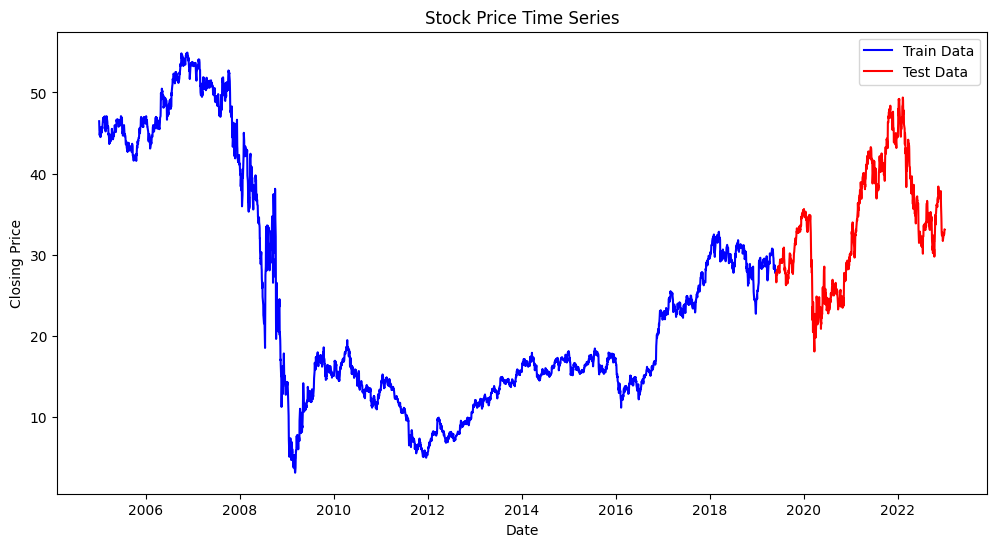

In [128]:
data = pd.read_csv("BAC.csv", parse_dates=["Date"], index_col="Date")

# Split into train and test
split_idx = int(len(data) * 0.8)
train_data = data[:split_idx]
test_data = data[split_idx:]

# Plot the train and test data
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data["Close"], label="Train Data", color="blue")
plt.plot(test_data.index, test_data["Close"], label="Test Data", color="red")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Stock Price Time Series")
plt.legend()
plt.show()

In [129]:
def calculate_accuracy_metrics(hidden_states, df):
    # Align returns with hidden states
    returns = df['Returns'].iloc[-len(hidden_states):]

    actual_directions = (returns > 0).astype(int)
    
    # Get state-wise average returns
    unique_states = np.unique(hidden_states)  # Ensure we only iterate over actual states
    state_directions = {}

    for state in unique_states:
        mask = hidden_states == state
        state_returns_mean = returns[mask].mean()
        state_directions[state] = 1 if state_returns_mean > 0 else 0
    
    # Fix: Use `.get(state, default_value)` to prevent KeyError
    predicted_directions = np.array([state_directions.get(state, 0) for state in hidden_states])
    
    # Calculate metrics
    accuracy = np.mean(predicted_directions == actual_directions)
    
    # Calculate precision, recall, and f1 for "up" movement (1)
    true_pos = np.sum((predicted_directions == 1) & (actual_directions == 1))
    false_pos = np.sum((predicted_directions == 1) & (actual_directions == 0))
    false_neg = np.sum((predicted_directions == 0) & (actual_directions == 1))
    
    precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }


def evaluate_predictions(data, prediction_type="daily", n_states=2, n_mix=2, test_size=0.2, w_indicators = False, visualize = True):
    # Convert date to datetime and set as index if not already done
    if 'Date' in data.columns:
        data['Date'] = pd.to_datetime(data['Date'])
        data.set_index('Date', inplace=True)
    
    # Initialize predictor
    if w_indicators:
        predictor = StockGMMHMMPredictorWIndicators(n_states=n_states, n_mix=n_mix)
    else:
        predictor = StockGMMHMMPredictor(n_states=n_states, n_mix=n_mix)
    
    # Prepare data based on prediction type
    if prediction_type == "weekly":
        X, df = predictor.prepare_weekly_data(data)
    else:
        X, df = predictor.prepare_data(data)
    
    # Calculate split point
    split_idx = int(len(X) * (1 - test_size))
    
    # Split the data
    X_train = X[:split_idx]
    X_test = X[split_idx:]
    df_train = df.iloc[:split_idx]
    df_test = df.iloc[split_idx:]
    
    # Train model on training data
    predictor.train(X_train)
    
    # Get predictions for both train and test sets
    train_direction, train_confidence, train_state_returns, train_hidden_states = predictor.predict_direction(X_train, df_train)
    test_direction, test_confidence, test_state_returns, test_hidden_states = predictor.predict_direction(X_test, df_test)
    
    # Calculate metrics for both sets
    train_metrics = calculate_accuracy_metrics(train_hidden_states, df_train)
    test_metrics = calculate_accuracy_metrics(test_hidden_states, df_test)
    
    # Print results
    print(f"\nResults for {prediction_type.capitalize()} Prediction (n_states={n_states} and n_mix={n_mix}):")
    print(f"\nTraining Set Metrics:")
    for metric, value in train_metrics.items():
        print(f"{metric.capitalize()}: {value:.2%}")
    
    print(f"\nTest Set Metrics:")
    for metric, value in test_metrics.items():
        print(f"{metric.capitalize()}: {value:.2%}")
    
    print(f"\nPredicted Direction (Test Set): {test_direction}")
    print(f"Confidence: {test_confidence:.2%}")
    print("\nState Analysis (Test Set):")
    for state, ret in test_state_returns.items():
        print(f"State {state} Average Return: {ret:.2%}")
    
    if visualize:
        # Create visualizations
        visualizer = StockHMMVisualizer()
        
        # Plot training set
        plt.figure(figsize=(15, 10))
        plt.suptitle("Training Set")
        visualizer.plot_states_and_prices(df_train, train_hidden_states, n_states, n_mix, prediction_type)
        
        # Plot test set
        plt.figure(figsize=(15, 10))
        plt.suptitle("Test Set")
        visualizer.plot_states_and_prices(df_test, test_hidden_states, n_states, n_mix, prediction_type)
        
        # Plot transition matrix
        visualizer.plot_state_transitions(predictor.hmm_model, n_states)
    
    return {
        'predictor': predictor,
        'X_train': X_train,
        'X_test': X_test,
        'df_train': df_train,
        'df_test': df_test,
        'train_hidden_states': train_hidden_states,
        'test_hidden_states': test_hidden_states,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics
    }


Results for Daily Prediction (n_states=2 and n_mix=2):

Training Set Metrics:
Accuracy: 50.97%
Precision: 50.43%
Recall: 62.08%
F1_score: 55.65%

Test Set Metrics:
Accuracy: 51.21%
Precision: 51.21%
Recall: 100.00%
F1_score: 67.74%

Predicted Direction (Test Set): Up
Confidence: 96.66%

State Analysis (Test Set):
State 0 Average Return: 0.05%
State 1 Average Return: 0.17%


<Figure size 1500x1000 with 0 Axes>

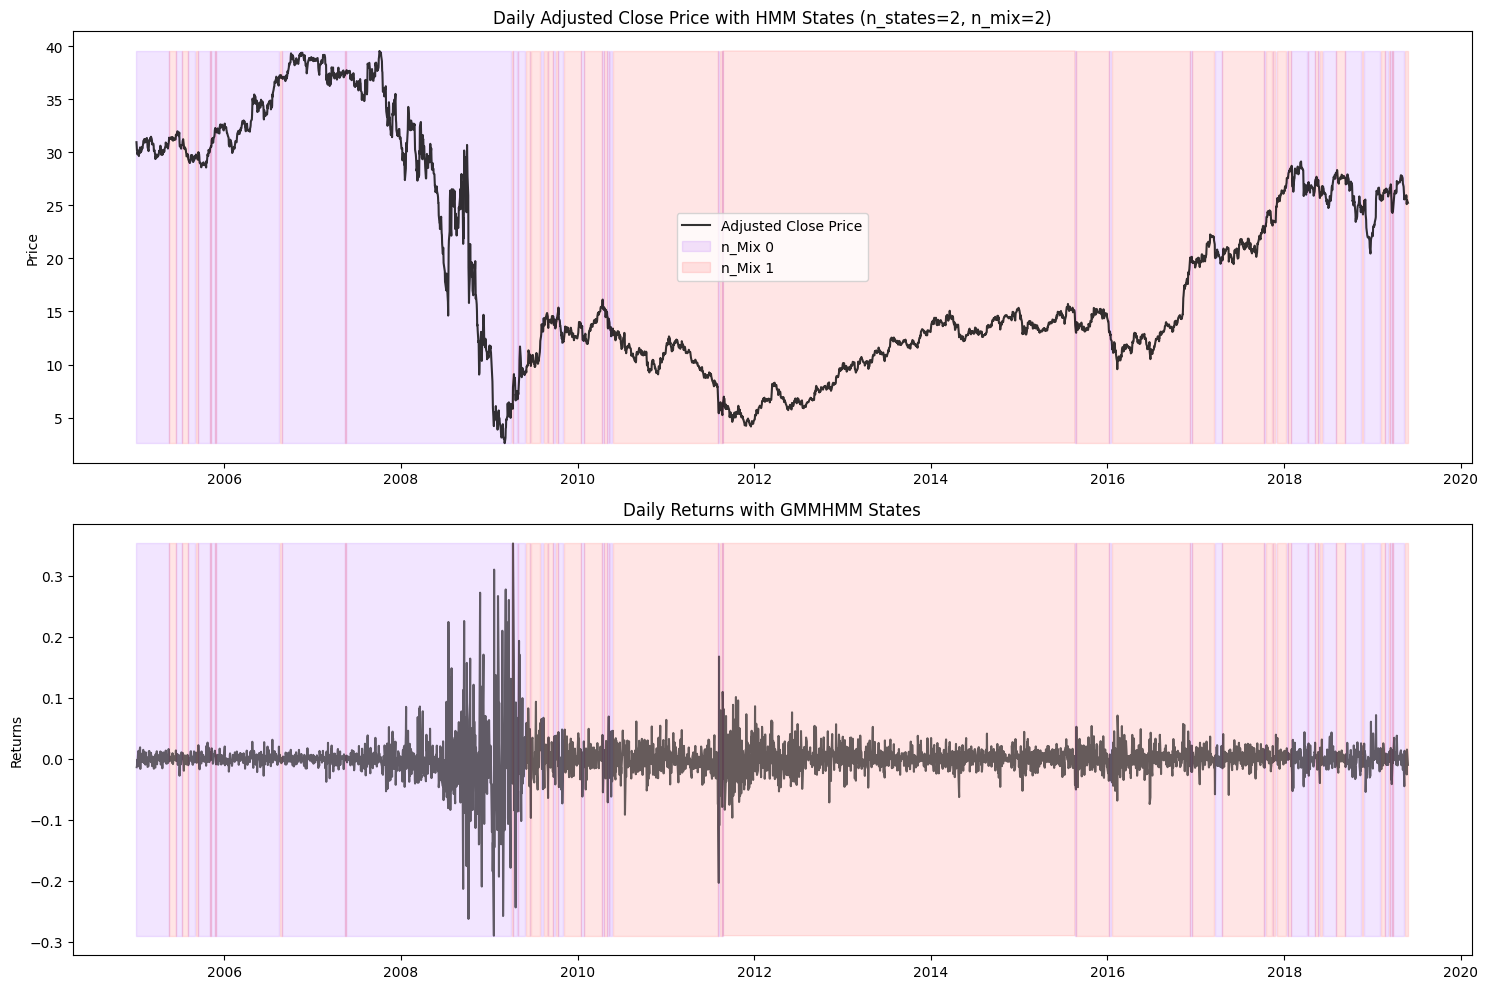

<Figure size 1500x1000 with 0 Axes>

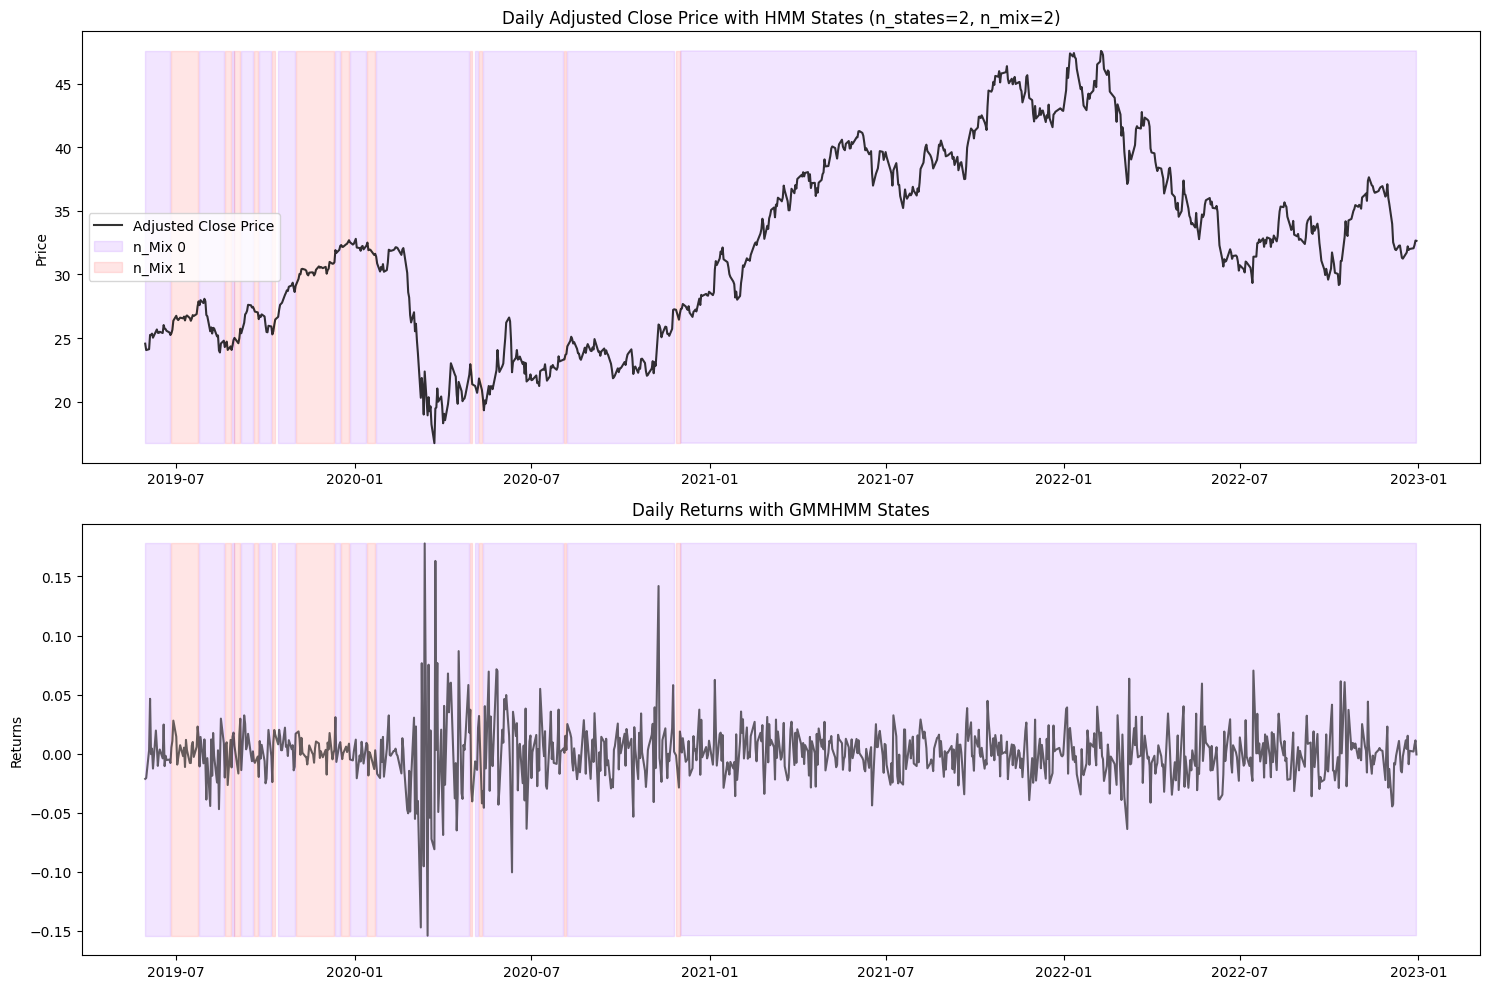

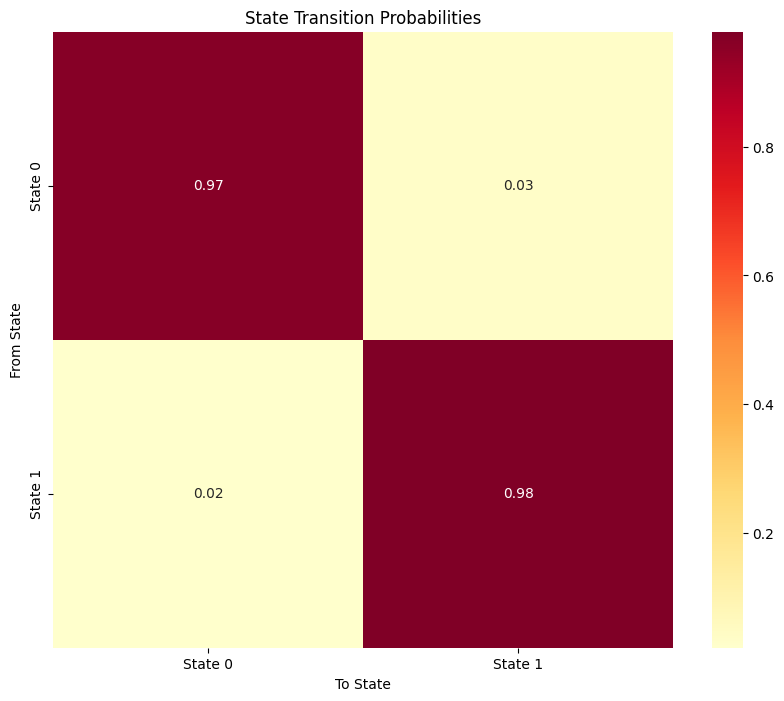


Results for Daily Prediction (n_states=2 and n_mix=3):

Training Set Metrics:
Accuracy: 51.30%
Precision: 50.79%
Recall: 55.35%
F1_score: 52.97%

Test Set Metrics:
Accuracy: 51.21%
Precision: 51.21%
Recall: 100.00%
F1_score: 67.74%

Predicted Direction (Test Set): Up
Confidence: 95.55%

State Analysis (Test Set):
State 0 Average Return: 0.06%
State 1 Average Return: 0.02%


<Figure size 1500x1000 with 0 Axes>

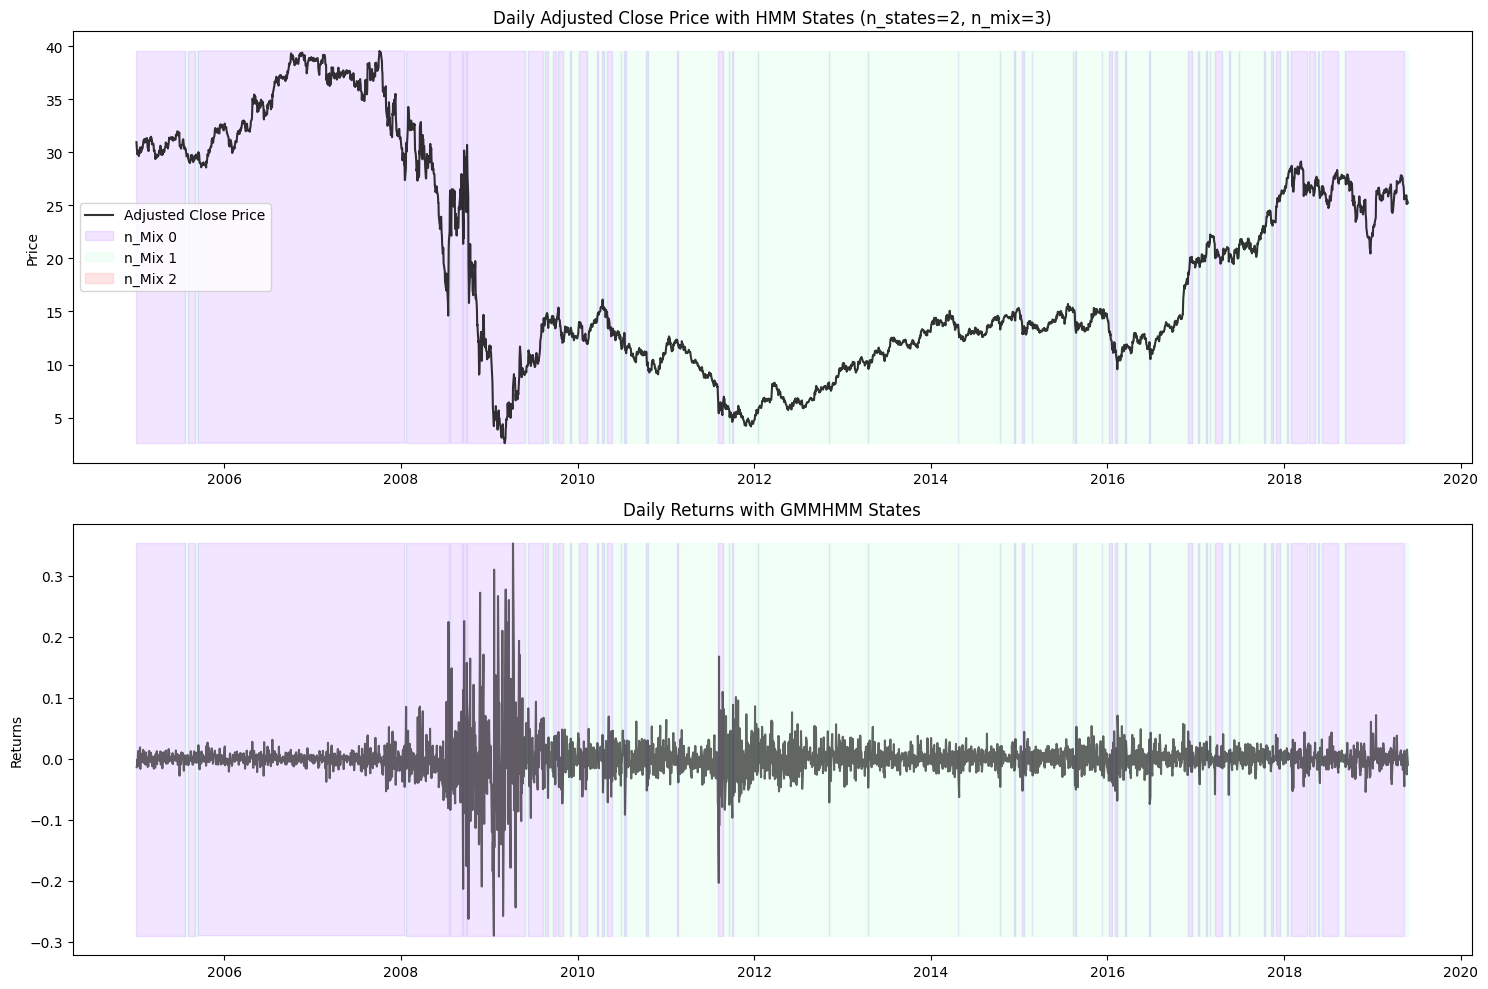

<Figure size 1500x1000 with 0 Axes>

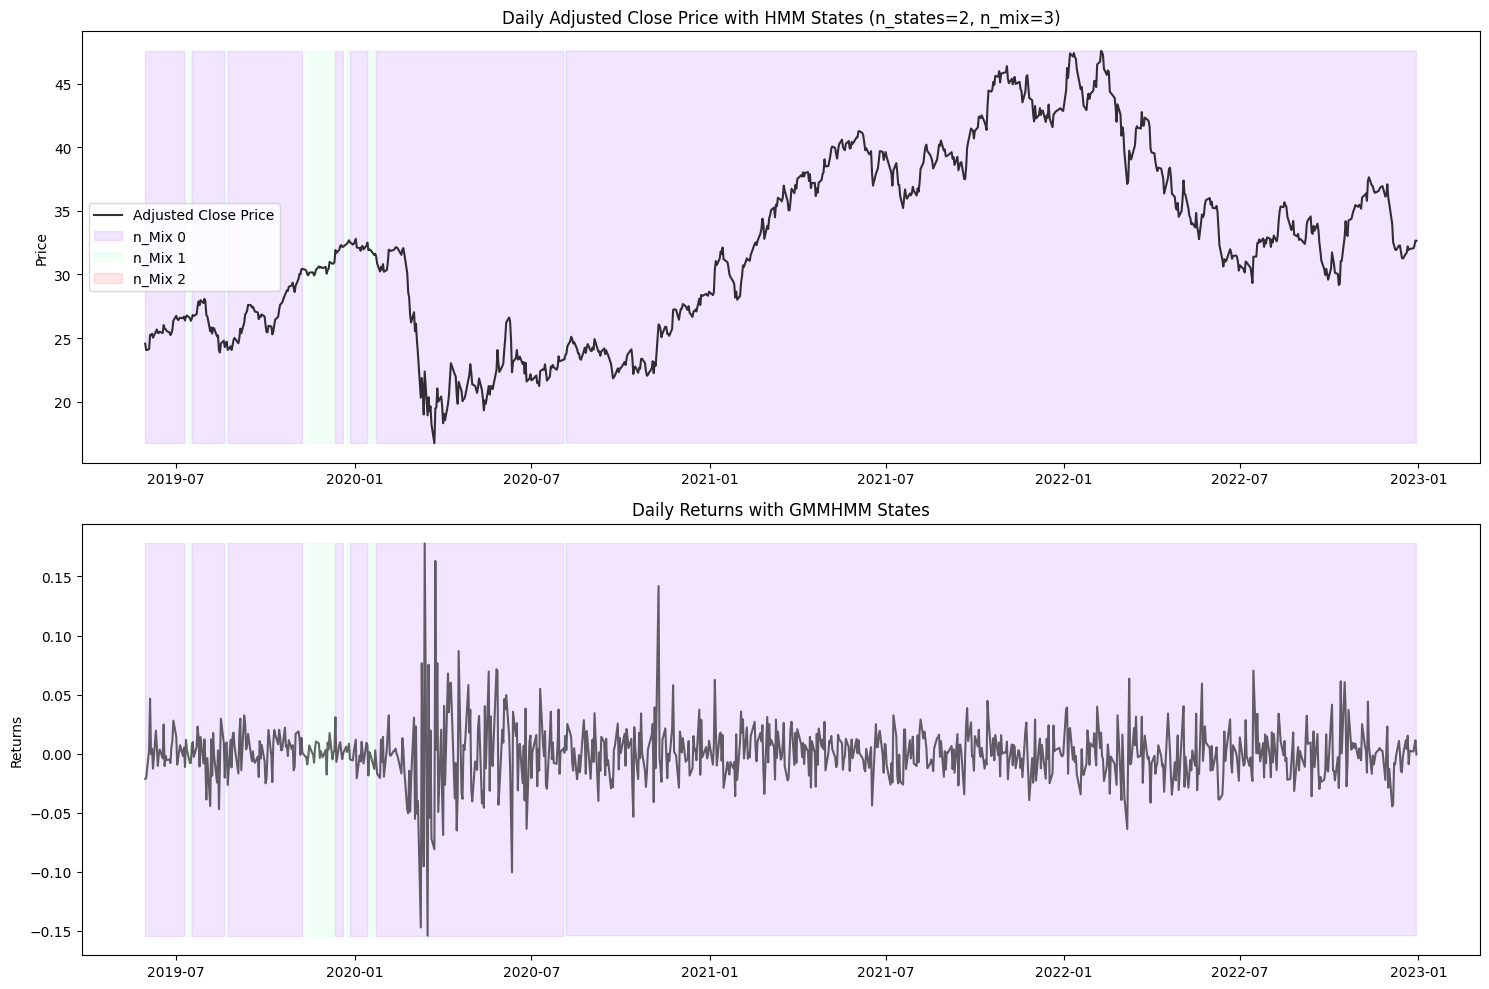

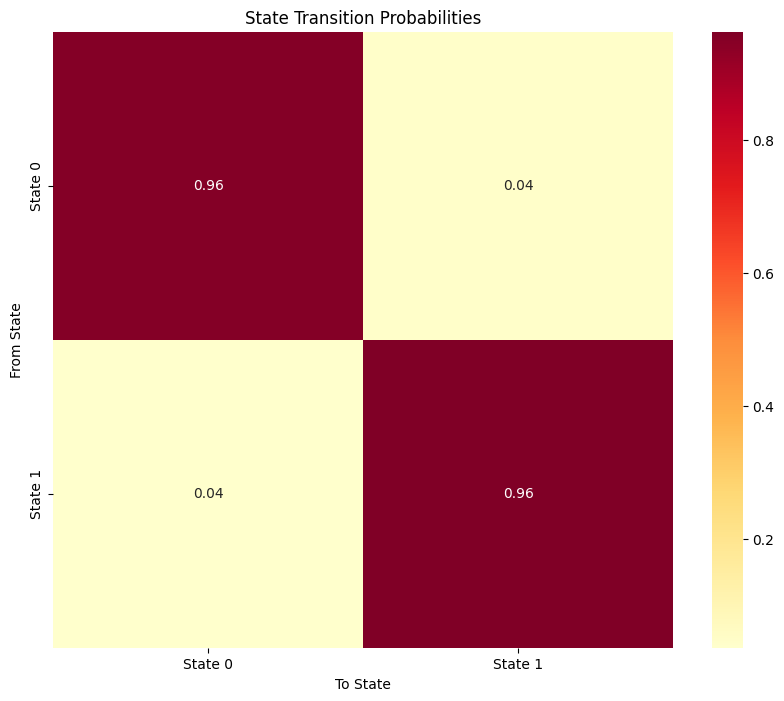

Model is not converging.  Current: -10735.926494915519 is not greater than -10715.4539941079. Delta is -20.472500807618417



Results for Daily Prediction (n_states=2 and n_mix=4):

Training Set Metrics:
Accuracy: 51.08%
Precision: 50.52%
Recall: 62.64%
F1_score: 55.93%

Test Set Metrics:
Accuracy: 51.21%
Precision: 51.21%
Recall: 100.00%
F1_score: 67.74%

Predicted Direction (Test Set): Up
Confidence: 95.83%

State Analysis (Test Set):
State 0 Average Return: 0.32%
State 1 Average Return: 0.03%


<Figure size 1500x1000 with 0 Axes>

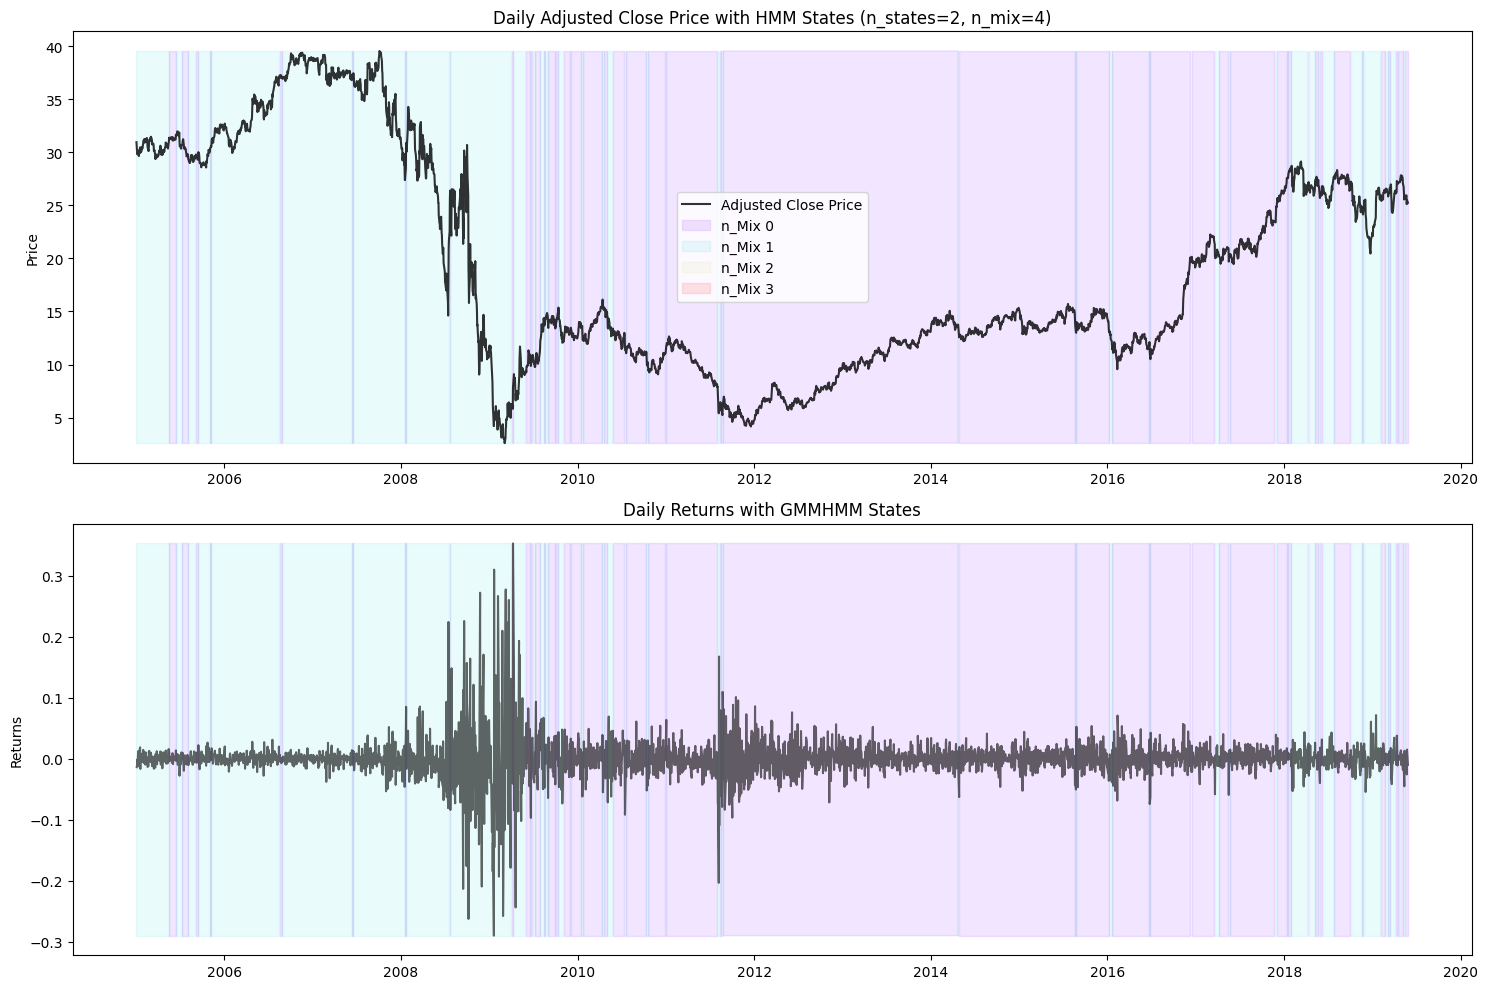

<Figure size 1500x1000 with 0 Axes>

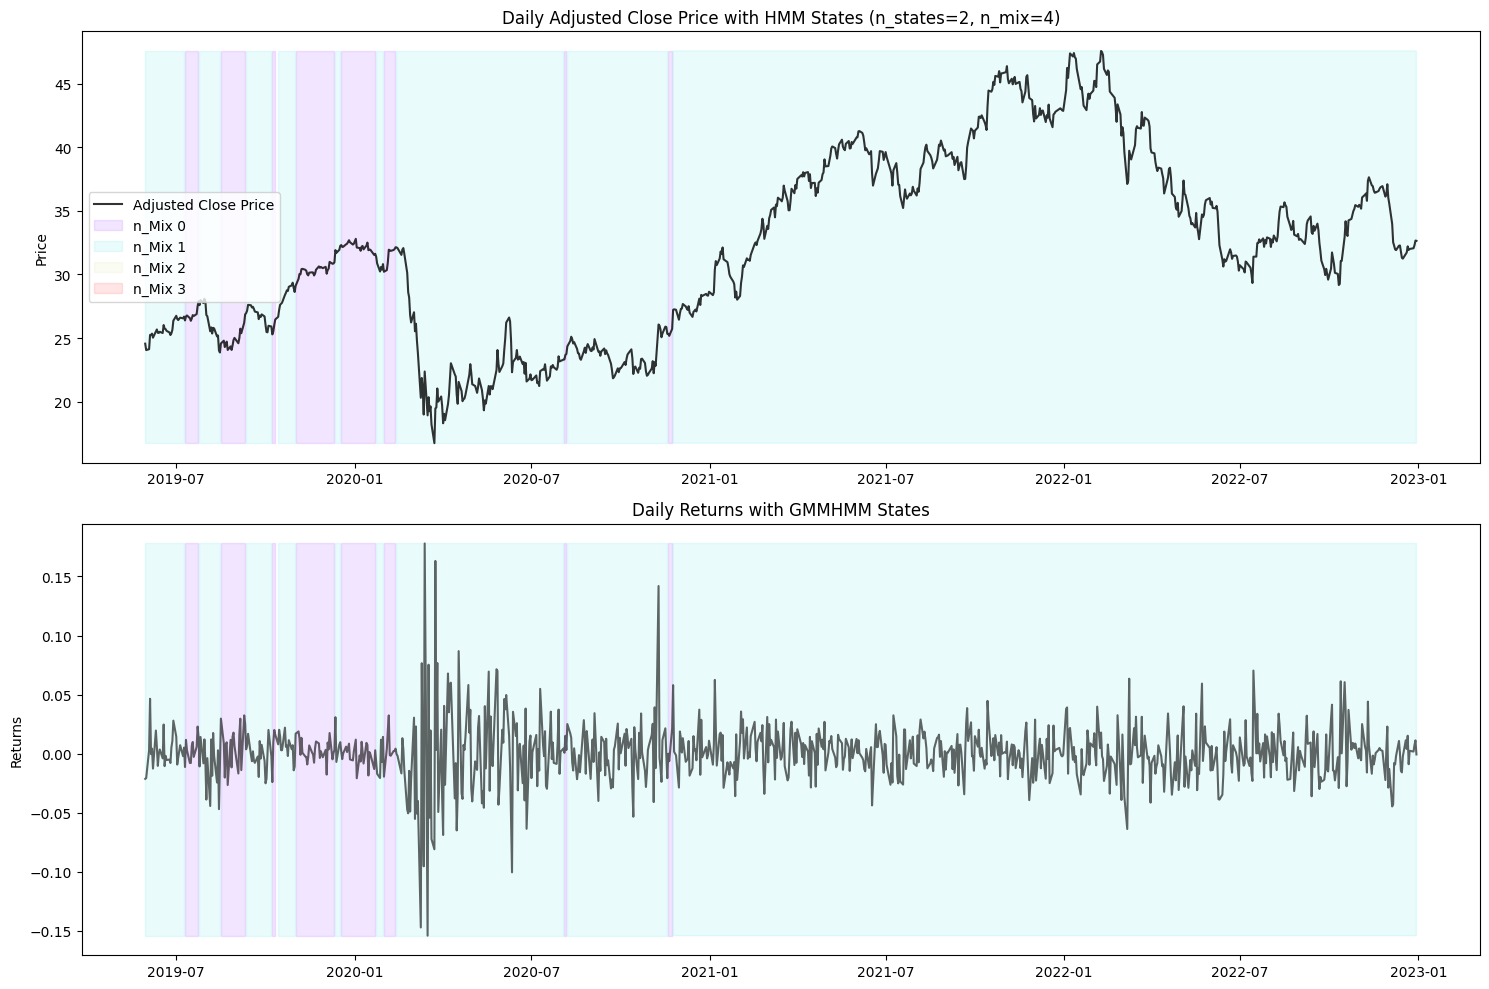

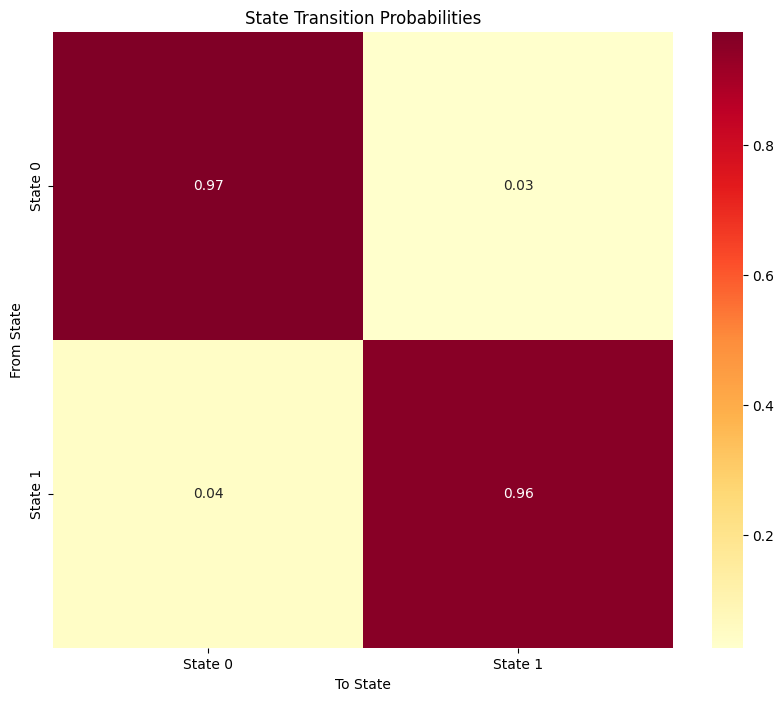


Model Comparison (Test Set Metrics):

Accuracy Comparison:
daily_2_states: 51.21%
daily_3_states: 51.21%
daily_4_states: 51.21%


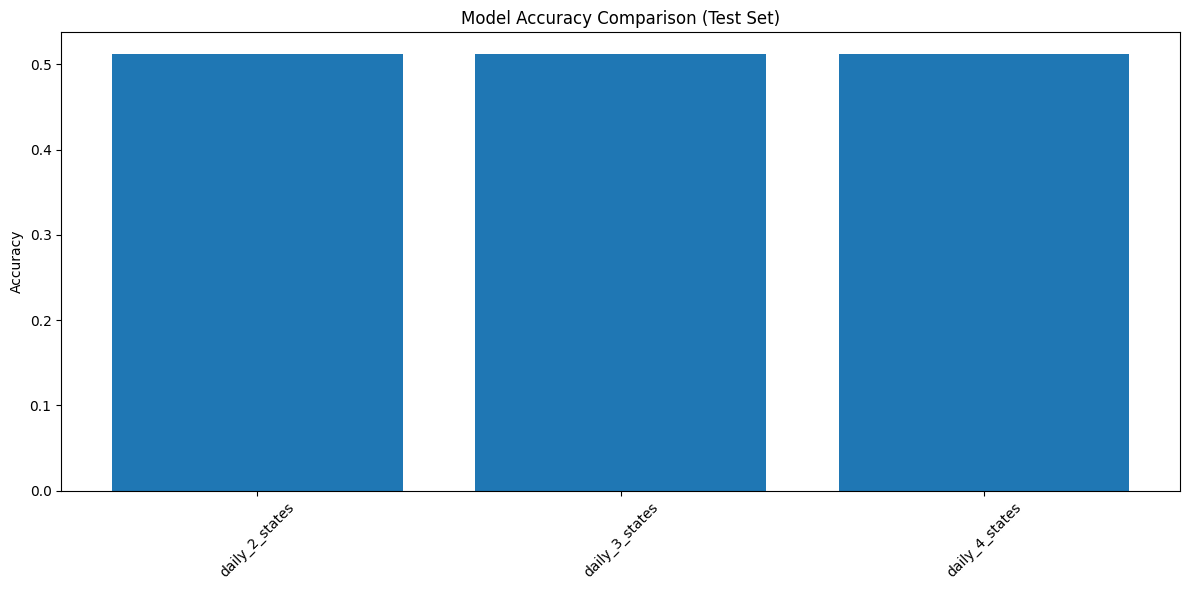

In [130]:
model_results = {}
data = pd.read_csv('BAC.csv')
# Try different numbers of states for daily prediction
for n_mix in [2, 3, 4]:
    model_results[f'daily_{n_mix}_states'] = evaluate_predictions(data, "daily", n_mix=n_mix)

# Compare models
print("\nModel Comparison (Test Set Metrics):")
print("\nAccuracy Comparison:")
for model_name, results in model_results.items():
    print(f"{model_name}: {results['test_metrics']['accuracy']:.2%}")

# Create comparison plot
plt.figure(figsize=(12, 6))
accuracies = [results['test_metrics']['accuracy'] for results in model_results.values()]
model_names = list(model_results.keys())

plt.bar(model_names, accuracies)
plt.title('Model Accuracy Comparison (Test Set)')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()


Results for Daily Prediction (n_states=2 and n_mix=2):

Training Set Metrics:
Accuracy: 49.67%
Precision: 49.67%
Recall: 100.00%
F1_score: 66.37%

Test Set Metrics:
Accuracy: 51.22%
Precision: 51.22%
Recall: 100.00%
F1_score: 67.74%

Predicted Direction (Test Set): Up
Confidence: 99.67%

State Analysis (Test Set):
State 0 Average Return: 0.06%
State 1 Average Return: nan%


<Figure size 1500x1000 with 0 Axes>

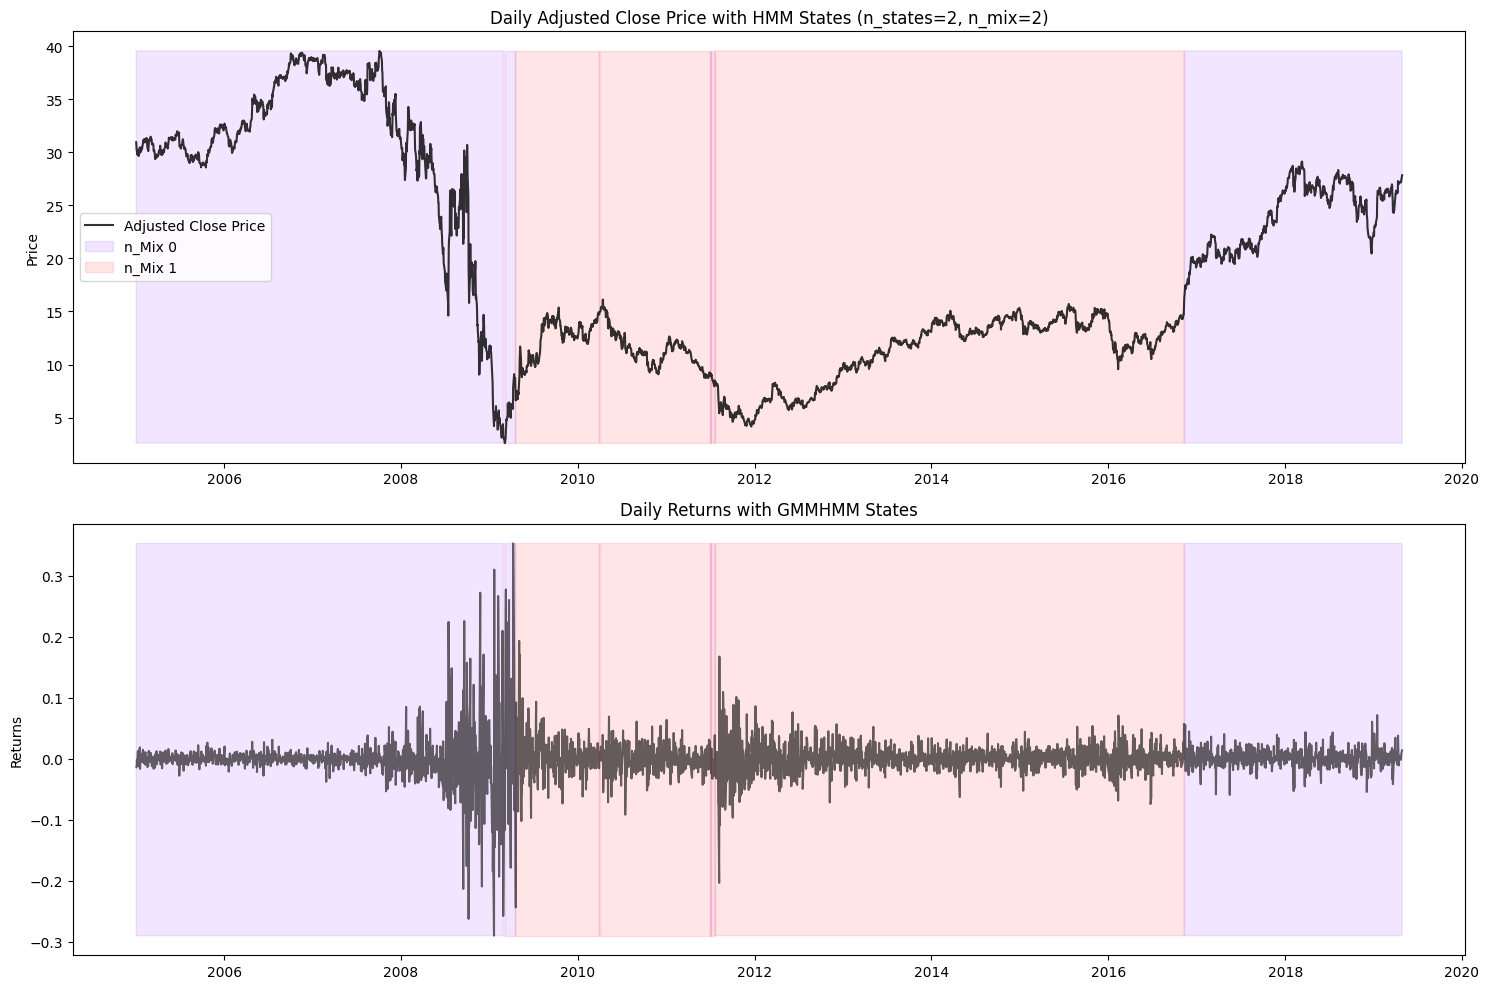

<Figure size 1500x1000 with 0 Axes>

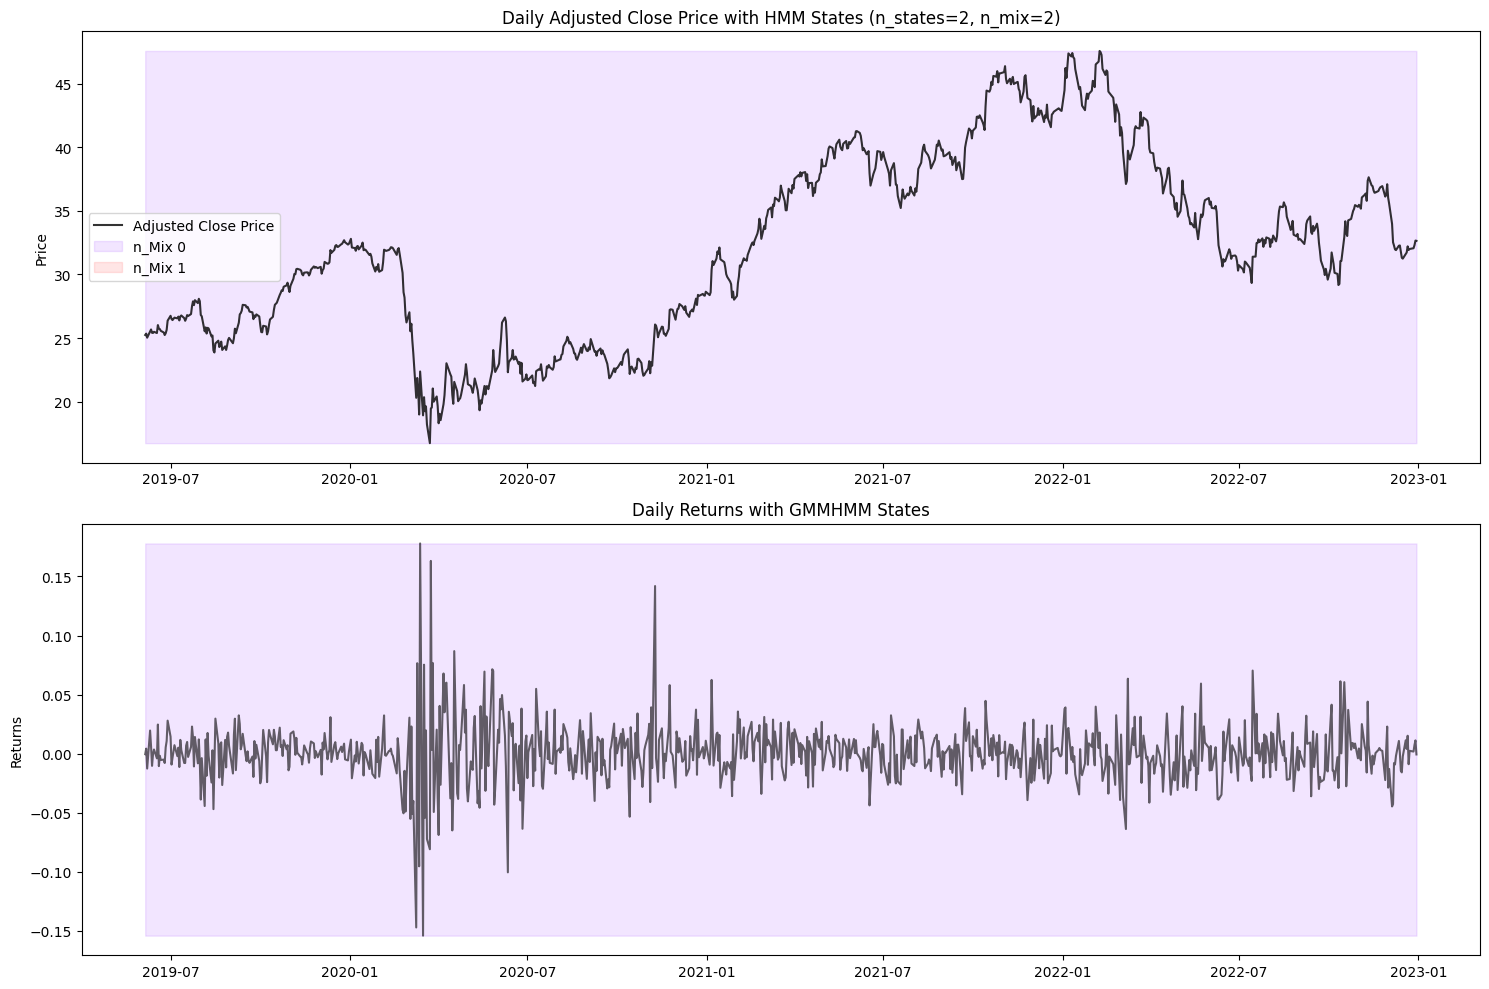

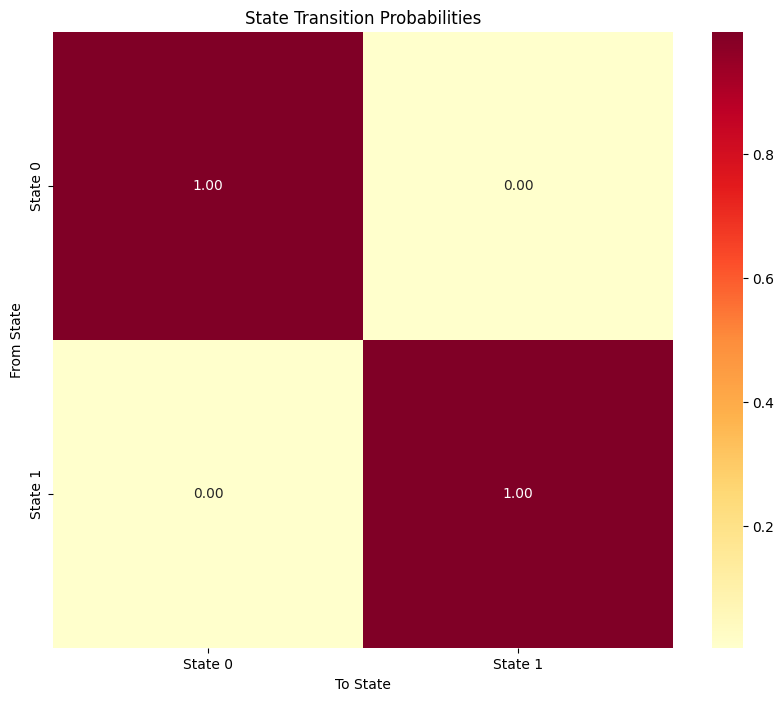


Results for Daily Prediction (n_states=2 and n_mix=3):

Training Set Metrics:
Accuracy: 52.94%
Precision: 51.93%
Recall: 70.78%
F1_score: 59.91%

Test Set Metrics:
Accuracy: 54.55%
Precision: 56.02%
Recall: 52.38%
F1_score: 54.14%

Predicted Direction (Test Set): Down
Confidence: 97.00%

State Analysis (Test Set):
State 0 Average Return: 0.21%
State 1 Average Return: -0.09%


<Figure size 1500x1000 with 0 Axes>

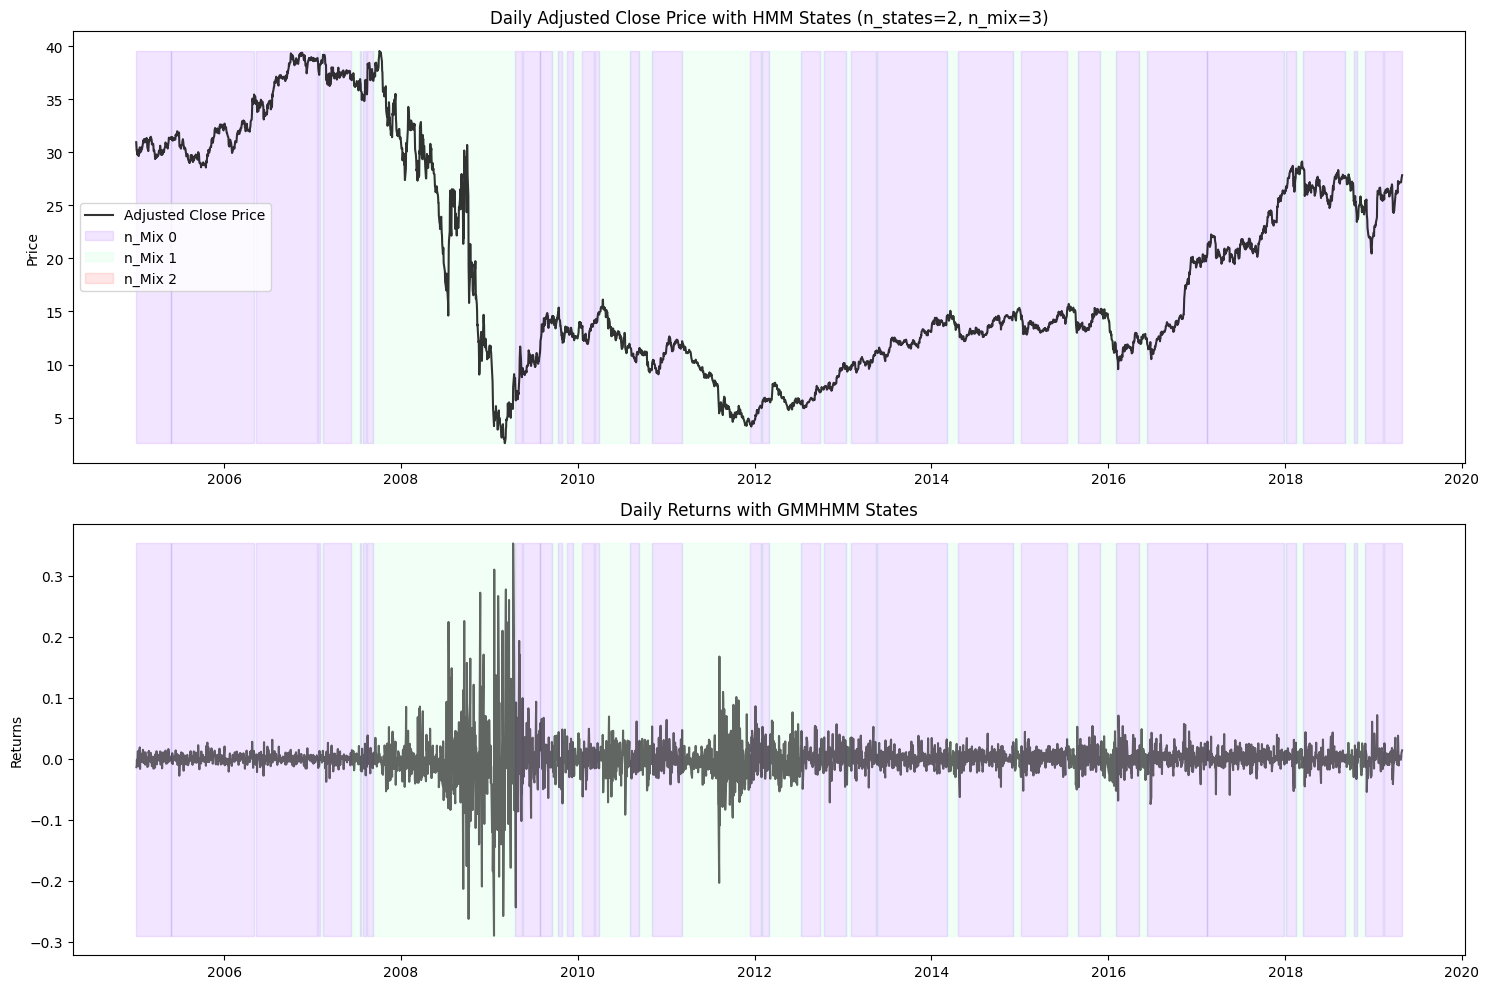

<Figure size 1500x1000 with 0 Axes>

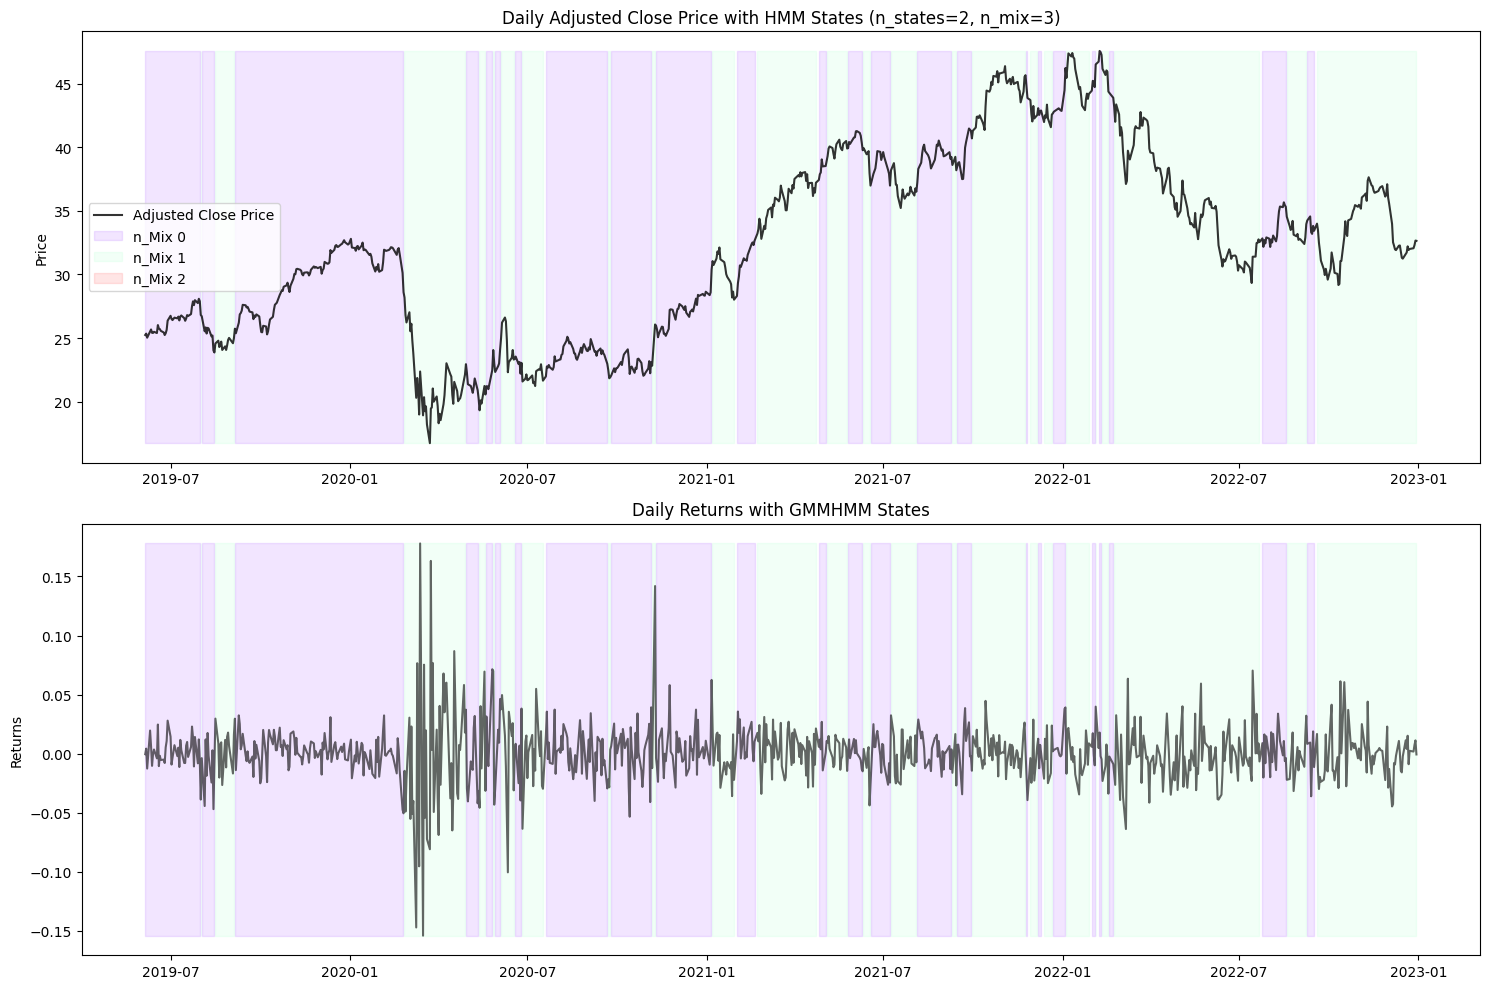

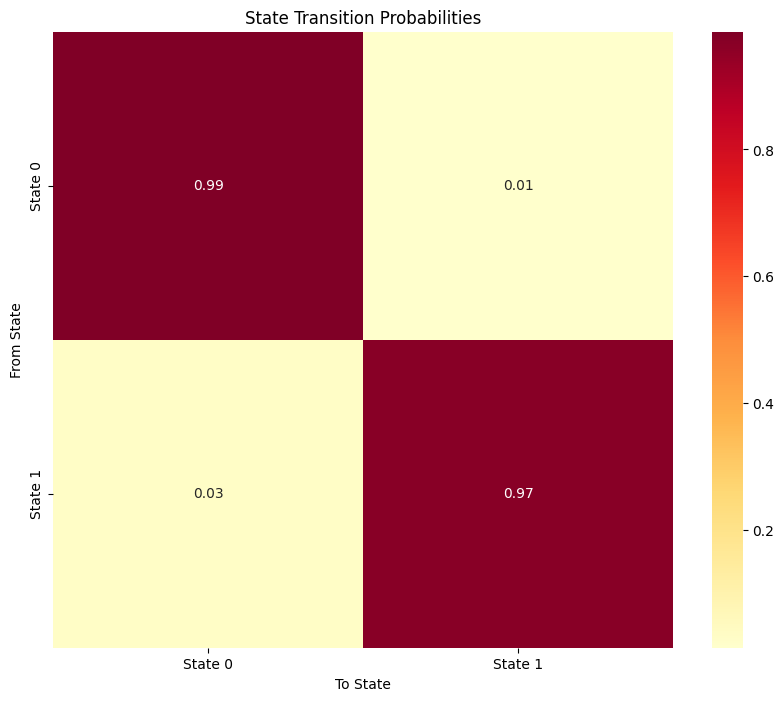


Results for Daily Prediction (n_states=2 and n_mix=4):

Training Set Metrics:
Accuracy: 49.67%
Precision: 49.67%
Recall: 100.00%
F1_score: 66.37%

Test Set Metrics:
Accuracy: 51.00%
Precision: 51.19%
Recall: 93.07%
F1_score: 66.05%

Predicted Direction (Test Set): Up
Confidence: 98.00%

State Analysis (Test Set):
State 0 Average Return: -0.32%
State 1 Average Return: 0.09%


<Figure size 1500x1000 with 0 Axes>

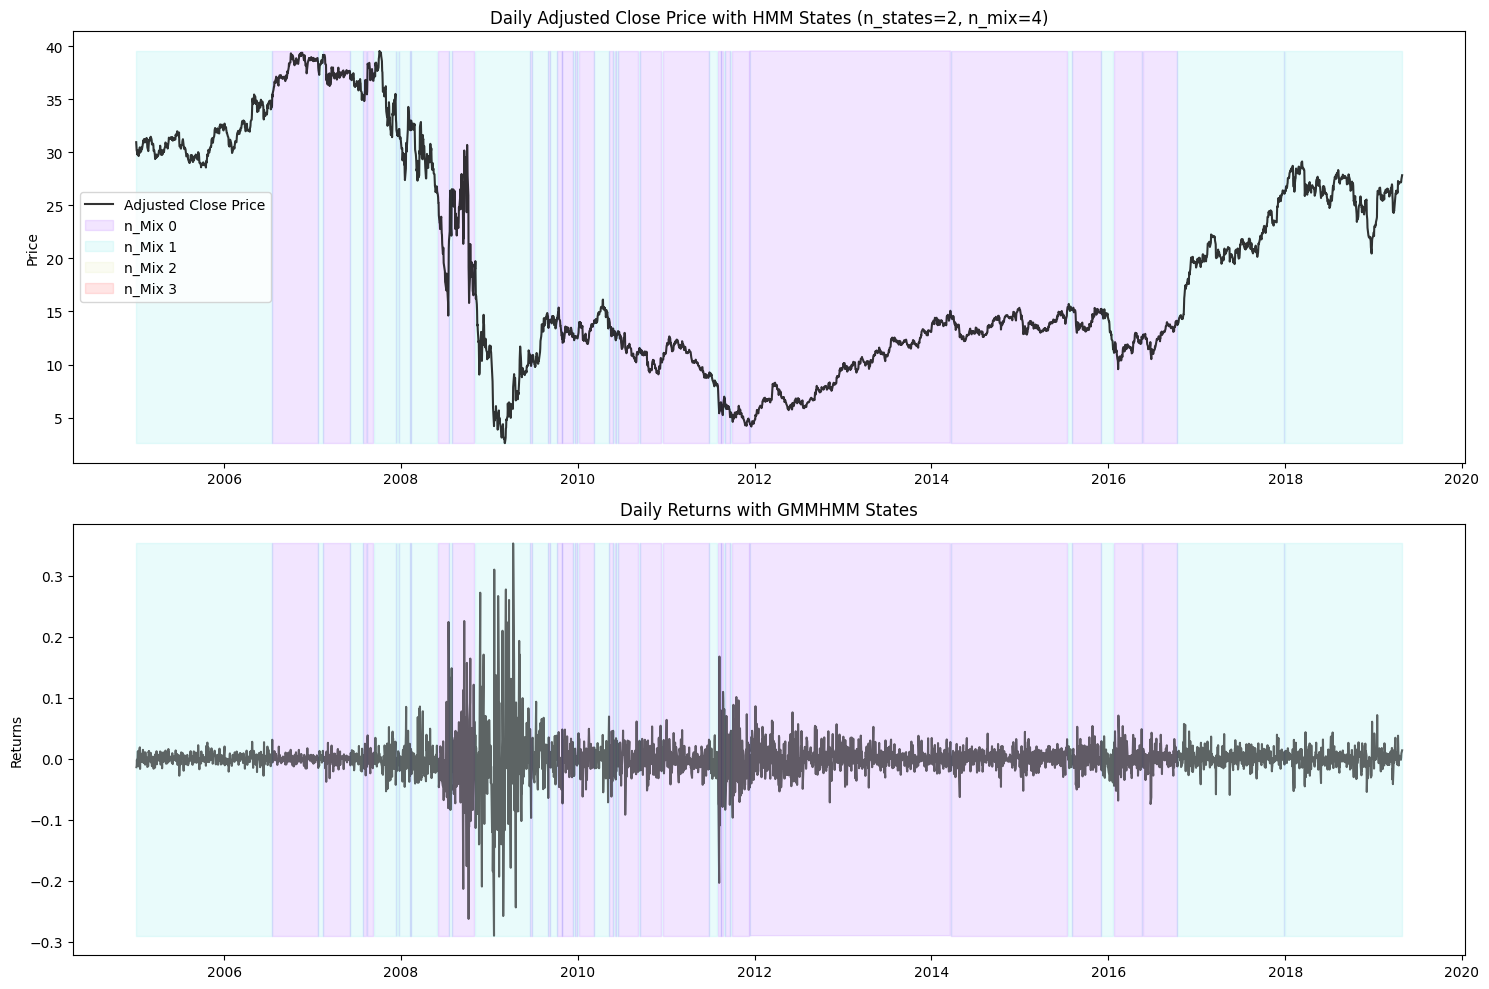

<Figure size 1500x1000 with 0 Axes>

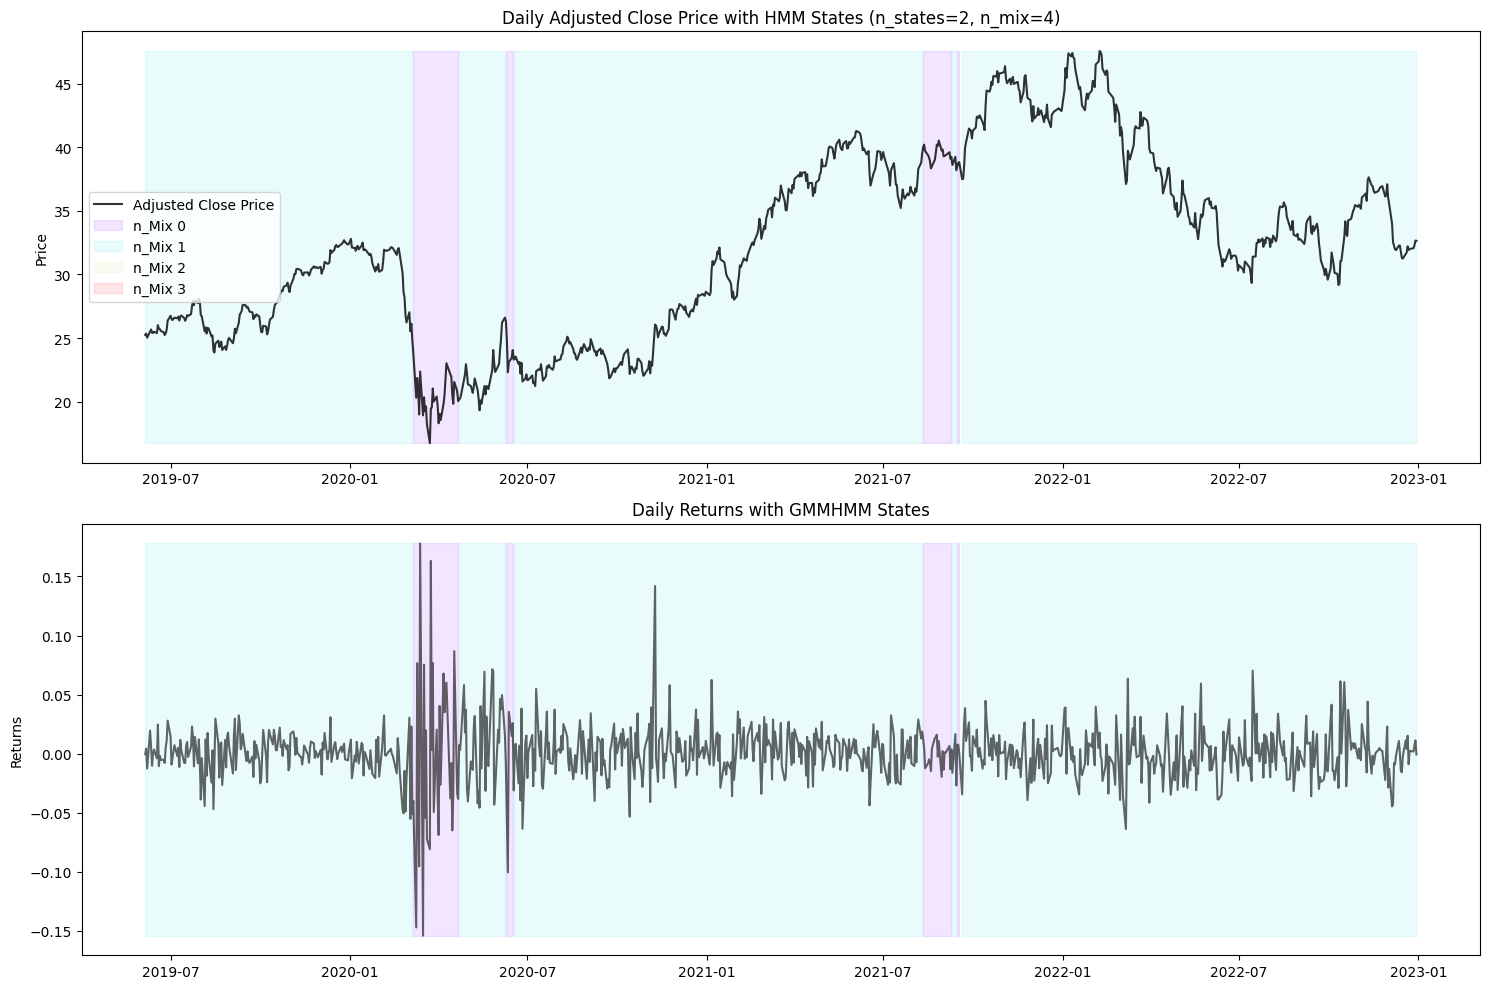

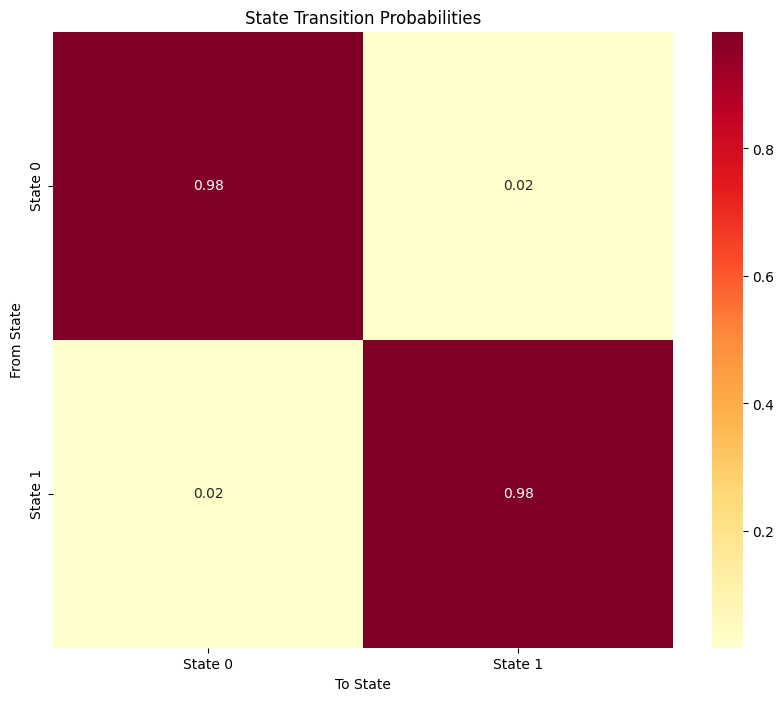


Model Comparison (Test Set Metrics):

Accuracy Comparison:
daily_2_states,2_mixtures_wIndicators: 51.22%
daily_2_states,3_mixtures_wIndicators: 54.55%
daily_2_states,4_mixtures_wIndicators: 51.00%


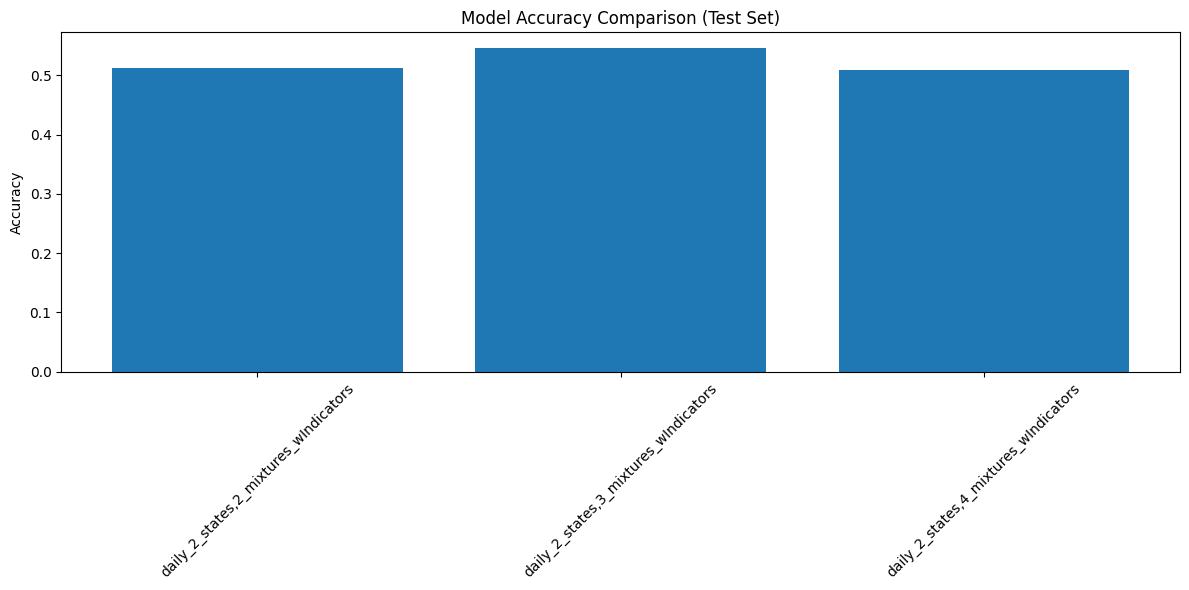

In [131]:
model_results = {}
data = pd.read_csv('BAC.csv')
# Try different numbers of states for daily prediction
for n_mix in [2, 3, 4]:
    model_results[f'daily_{2}_states,{n_mix}_mixtures_wIndicators'] = evaluate_predictions(data, "daily", n_mix=n_mix, w_indicators= True)

# Compare models
print("\nModel Comparison (Test Set Metrics):")
print("\nAccuracy Comparison:")
for model_name, results in model_results.items():
    print(f"{model_name}: {results['test_metrics']['accuracy']:.2%}")

# Create comparison plot
plt.figure(figsize=(12, 6))
accuracies = [results['test_metrics']['accuracy'] for results in model_results.values()]
model_names = list(model_results.keys())

plt.bar(model_names, accuracies)
plt.title('Model Accuracy Comparison (Test Set)')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [132]:
def calculate_cumulative_accuracy(hidden_states, df, window_size=50):
    """
    Calculate cumulative and rolling accuracy over time
    """
    # Align returns with hidden states
    returns = df['Returns'].iloc[-len(hidden_states):]
    actual_directions = (returns > 0).astype(int)
    
    # Get state-wise average returns
    unique_states = np.unique(hidden_states)
    state_directions = {}
    
    for state in unique_states:
        mask = hidden_states == state
        state_returns_mean = returns[mask].mean()
        state_directions[state] = 1 if state_returns_mean > 0 else 0
    
    predicted_directions = np.array([state_directions.get(state, 0) for state in hidden_states])
    
    # Calculate cumulative accuracy
    correct_predictions = predicted_directions == actual_directions
    cumulative_accuracy = np.cumsum(correct_predictions) / np.arange(1, len(correct_predictions) + 1)
    
    # Calculate rolling accuracy
    rolling_accuracy = pd.Series(correct_predictions).rolling(window=window_size, min_periods=1).mean()
    
    return cumulative_accuracy, rolling_accuracy, correct_predictions

def plot_cumulative_accuracy(results, window_size=50):
    """
    Plot cumulative and rolling accuracy for test set
    """
    # Get test set predictions and actual values
    hidden_states = results['test_hidden_states']
    df_test = results['df_test']
    
    # Calculate accuracies
    cumulative_accuracy, rolling_accuracy, correct_predictions = calculate_cumulative_accuracy(
        hidden_states, df_test, window_size
    )
    
    # Create plot
    plt.figure(figsize=(15, 10))
    
    # Plot cumulative accuracy
    plt.plot(df_test.index[-len(hidden_states):], 
             cumulative_accuracy, 
             label='Cumulative Accuracy', 
             linewidth=2)
    
    # Plot rolling accuracy
    plt.plot(df_test.index[-len(hidden_states):], 
             rolling_accuracy, 
             label=f'{window_size}-Day Rolling Accuracy', 
             linewidth=2)
    
    # Add horizontal line for overall accuracy
    overall_accuracy = np.mean(correct_predictions)
    plt.axhline(y=overall_accuracy, 
                color='r', 
                linestyle='--', 
                label=f'Overall Accuracy: {overall_accuracy:.2%}')
    
    plt.title('Accuracy Over Time in Test Set')
    plt.xlabel('Date')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return cumulative_accuracy, rolling_accuracy, correct_predictions

def evaluate_predictions_with_cumulative(data, prediction_type="daily", n_states=2, n_mix=2, test_size=0.2, w_indicators=False, window_size=50, visualize = False):
    # Run original evaluation
    results = evaluate_predictions(data, prediction_type, n_states, n_mix=n_mix, test_size=0.2, w_indicators=w_indicators, visualize=visualize)
    
    # Check if evaluate_predictions returned the expected keys
    if 'test_hidden_states' not in results or 'df_test' not in results:
        raise KeyError("evaluate_predictions did not return the expected keys ('test_hidden_states', 'df_test')")
    
    # Add cumulative accuracy analysis
    print("\nCalculating Cumulative Accuracy Metrics...")
    cumulative_accuracy, rolling_accuracy, correct_predictions = plot_cumulative_accuracy(results, window_size)
    
    # Add the accuracy information to results
    results.update({
        'cumulative_accuracy': cumulative_accuracy,
        'rolling_accuracy': rolling_accuracy,
        'correct_predictions': correct_predictions
    })
    
    # Print additional statistics
    print("\nCumulative Accuracy Analysis:")
    print(f"First Month Accuracy: {cumulative_accuracy[window_size]:.2%}")
    print(f"Mid-Period Accuracy: {cumulative_accuracy[len(cumulative_accuracy)//2]:.2%}")
    print(f"Final Accuracy: {cumulative_accuracy[-1]:.2%}")
    
    # Print rolling accuracy statistics
    print(f"\nRolling {window_size}-Day Accuracy Range:")
    print(f"Min: {rolling_accuracy.min():.2%}")
    print(f"Max: {rolling_accuracy.max():.2%}")
    print(f"Mean: {rolling_accuracy.mean():.2%}")
    
    return results


Evaluating model with 2 states, 2 states ...

Results for Daily Prediction (n_states=2 and n_mix=2):

Training Set Metrics:
Accuracy: 50.97%
Precision: 50.43%
Recall: 62.08%
F1_score: 55.65%

Test Set Metrics:
Accuracy: 51.21%
Precision: 51.21%
Recall: 100.00%
F1_score: 67.74%

Predicted Direction (Test Set): Up
Confidence: 96.66%

State Analysis (Test Set):
State 0 Average Return: 0.17%
State 1 Average Return: 0.05%

Calculating Cumulative Accuracy Metrics...

Cumulative Accuracy Analysis:
First Month Accuracy: 47.06%
Mid-Period Accuracy: 53.30%
Final Accuracy: 51.21%

Rolling 50-Day Accuracy Range:
Min: 0.00%
Max: 70.00%
Mean: 50.92%

Evaluating model with 2 states, 3 states ...

Results for Daily Prediction (n_states=2 and n_mix=3):

Training Set Metrics:
Accuracy: 50.69%
Precision: 50.22%
Recall: 58.07%
F1_score: 53.86%

Test Set Metrics:
Accuracy: 51.21%
Precision: 51.21%
Recall: 100.00%
F1_score: 67.74%

Predicted Direction (Test Set): Up
Confidence: 97.93%

State Analysis (Test

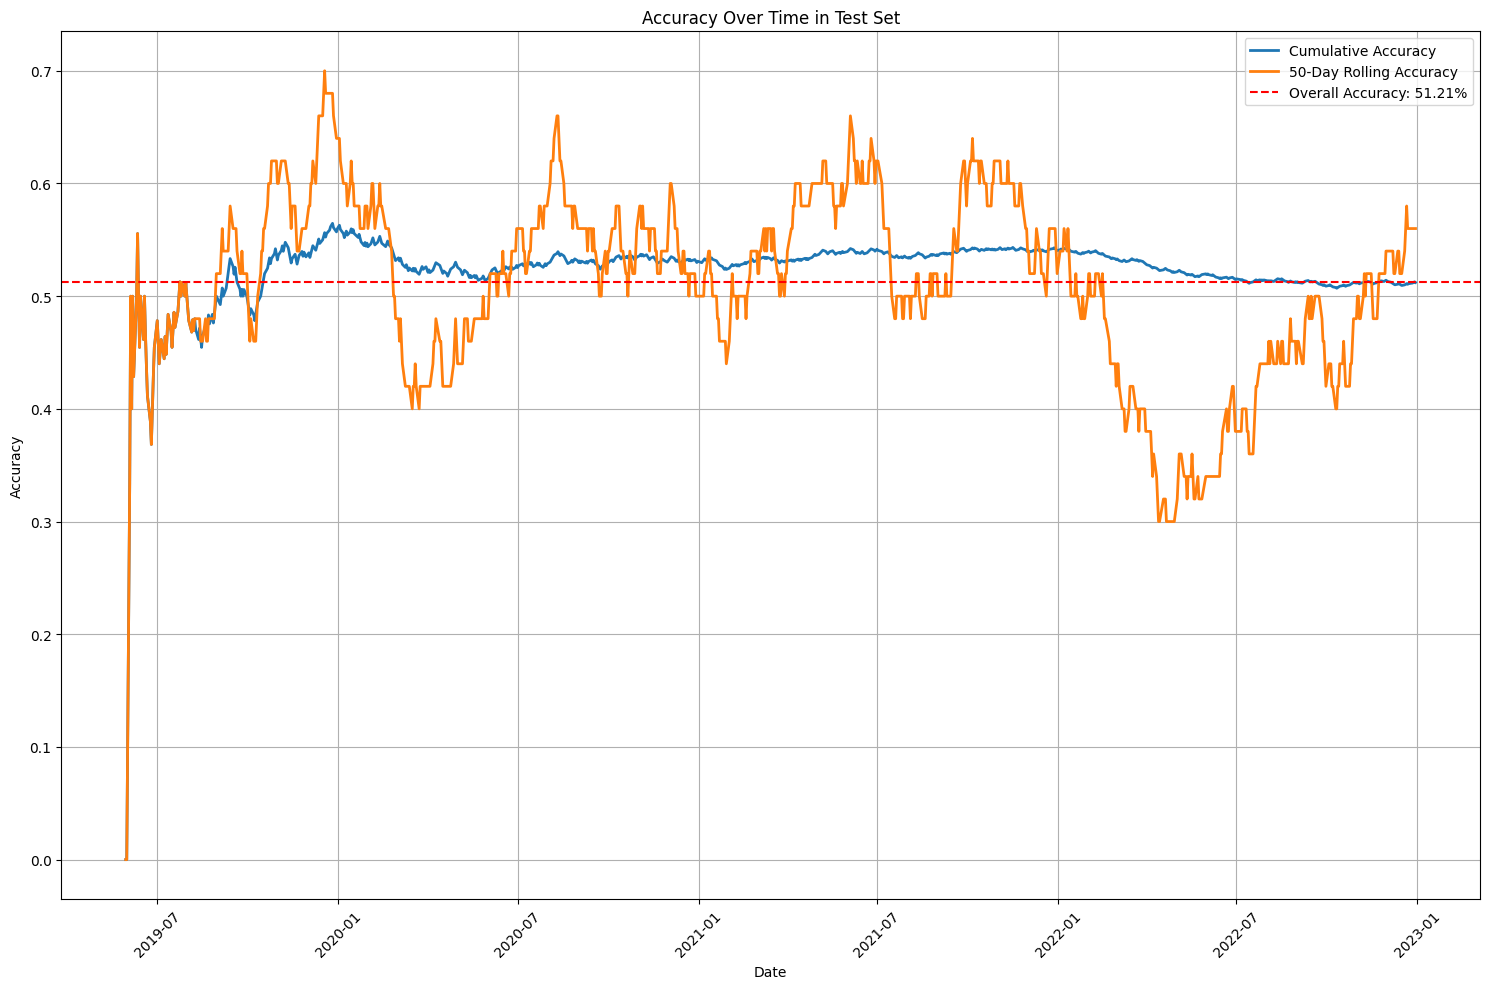

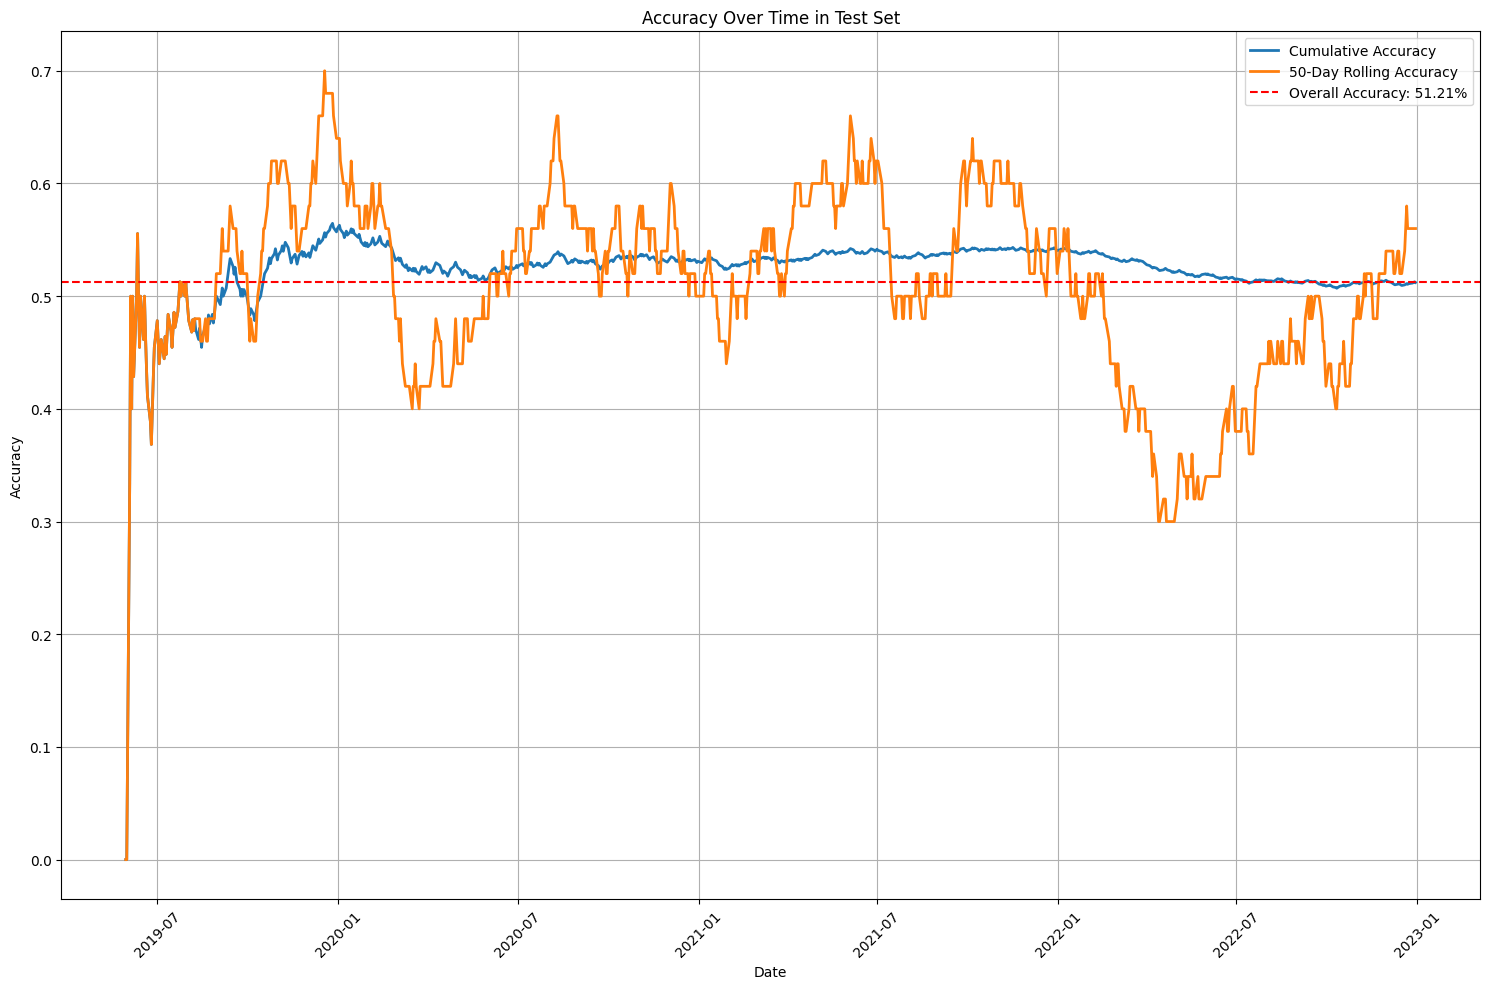

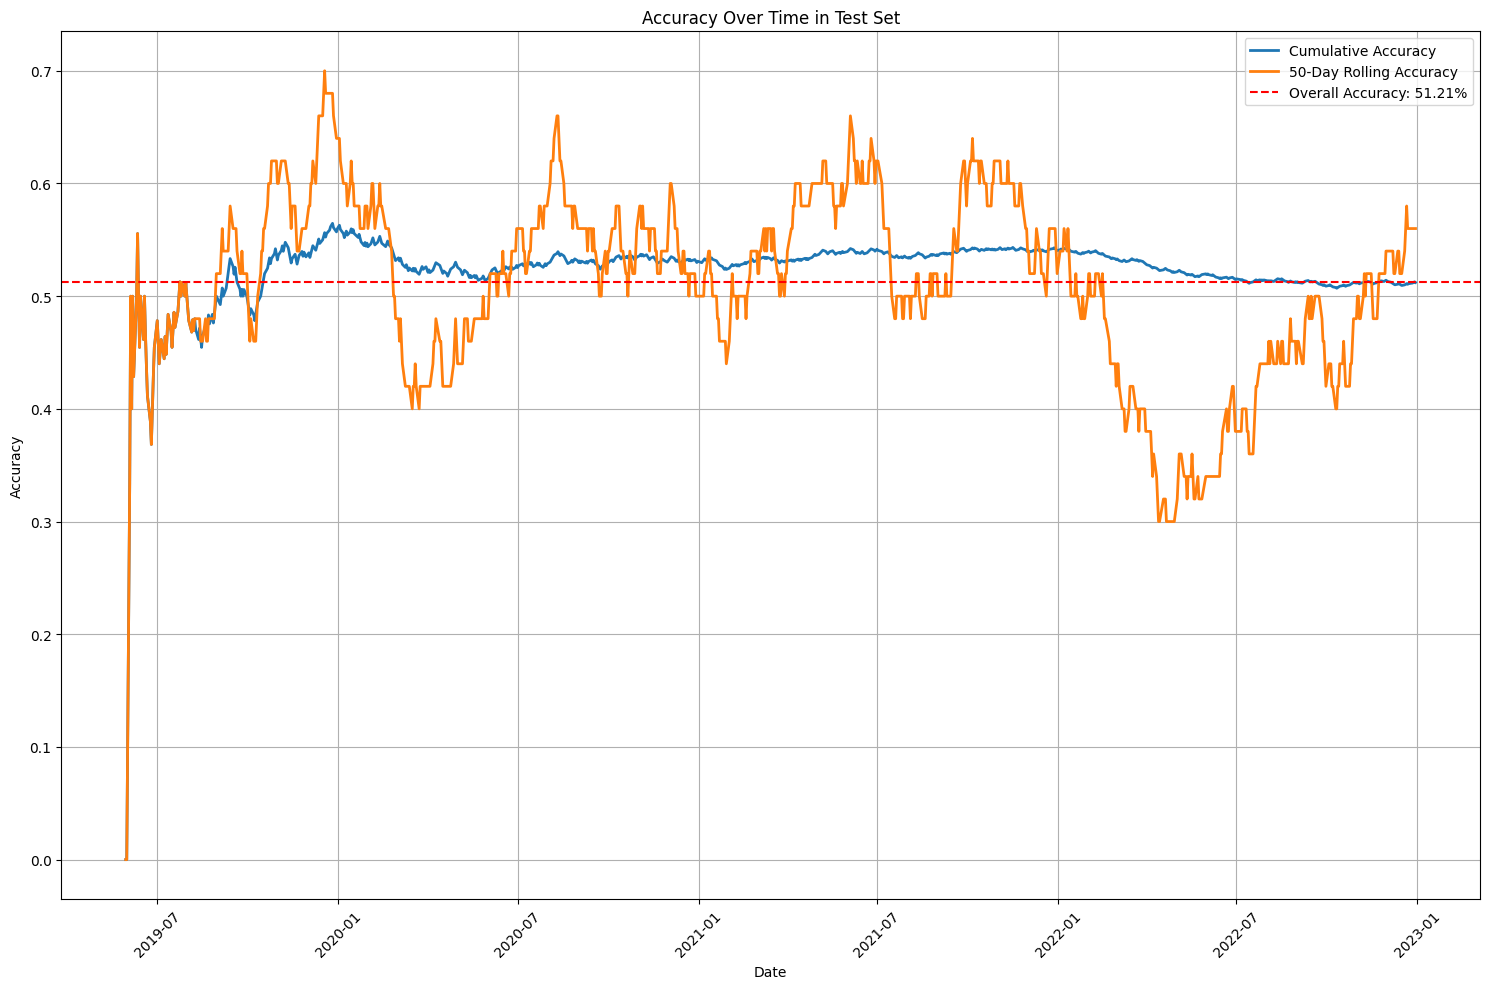

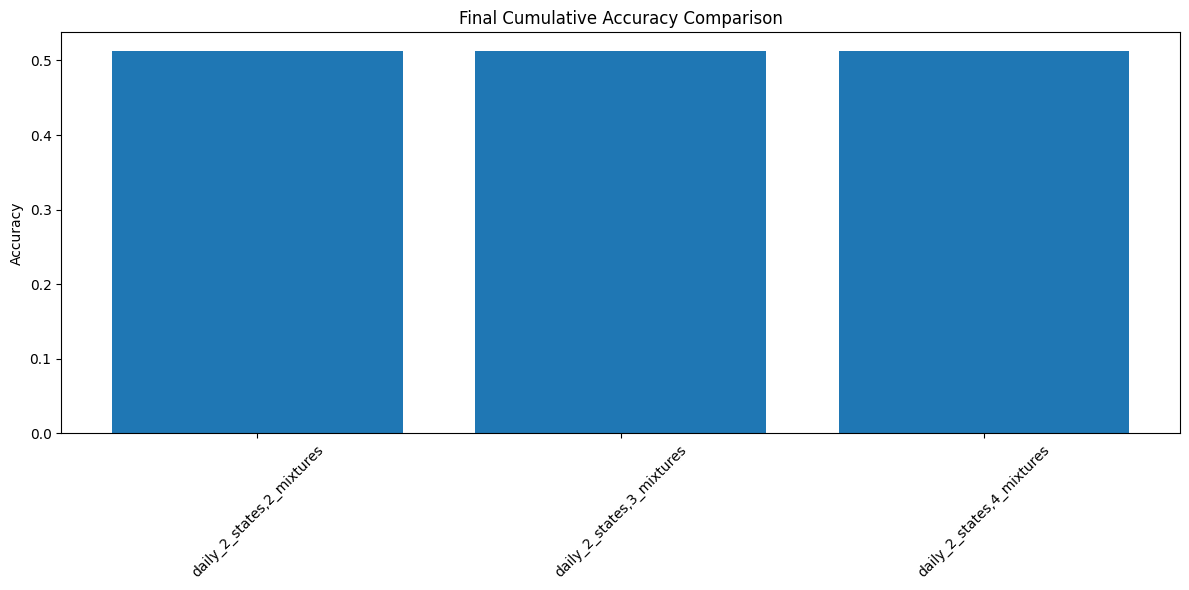


Evaluating model with 2 states...

Results for Daily Prediction (n_states=2 and n_mix=2):

Training Set Metrics:
Accuracy: 49.67%
Precision: 49.67%
Recall: 100.00%
F1_score: 66.37%

Test Set Metrics:
Accuracy: 51.22%
Precision: 51.22%
Recall: 100.00%
F1_score: 67.74%

Predicted Direction (Test Set): Up
Confidence: 99.67%

State Analysis (Test Set):
State 0 Average Return: 0.06%
State 1 Average Return: nan%

Calculating Cumulative Accuracy Metrics...

Cumulative Accuracy Analysis:
First Month Accuracy: 45.10%
Mid-Period Accuracy: 53.32%
Final Accuracy: 51.22%

Rolling 50-Day Accuracy Range:
Min: 0.00%
Max: 70.00%
Mean: 50.96%

Evaluating model with 3 states...

Results for Daily Prediction (n_states=2 and n_mix=3):

Training Set Metrics:
Accuracy: 52.94%
Precision: 51.93%
Recall: 70.78%
F1_score: 59.91%

Test Set Metrics:
Accuracy: 54.55%
Precision: 56.02%
Recall: 52.38%
F1_score: 54.14%

Predicted Direction (Test Set): Down
Confidence: 97.00%

State Analysis (Test Set):
State 0 Averag

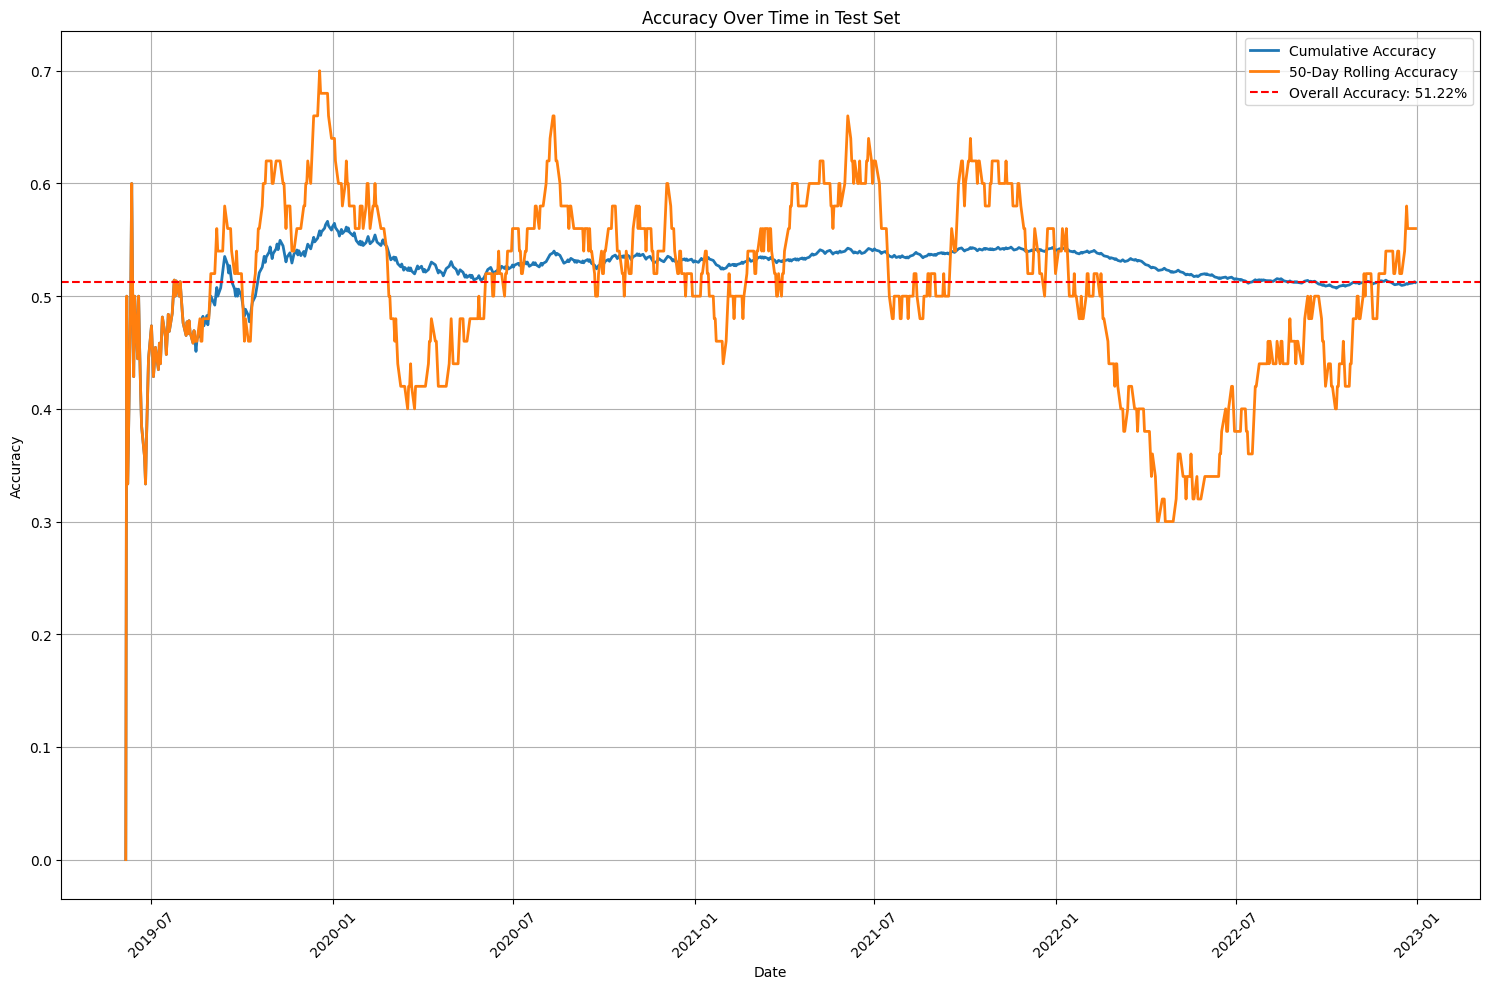

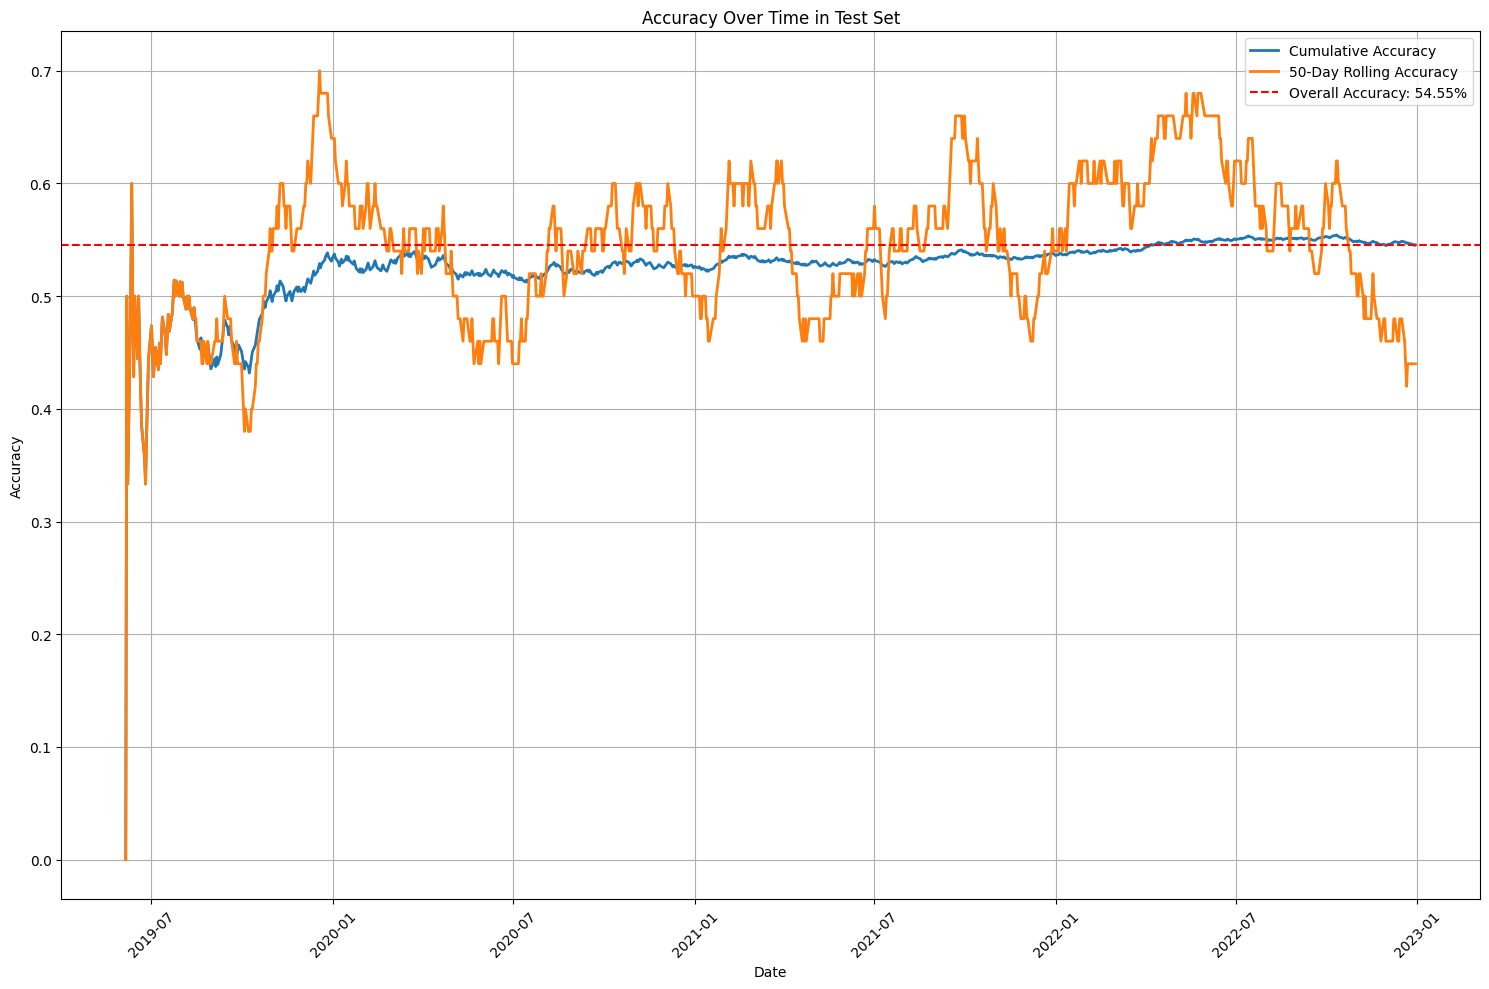

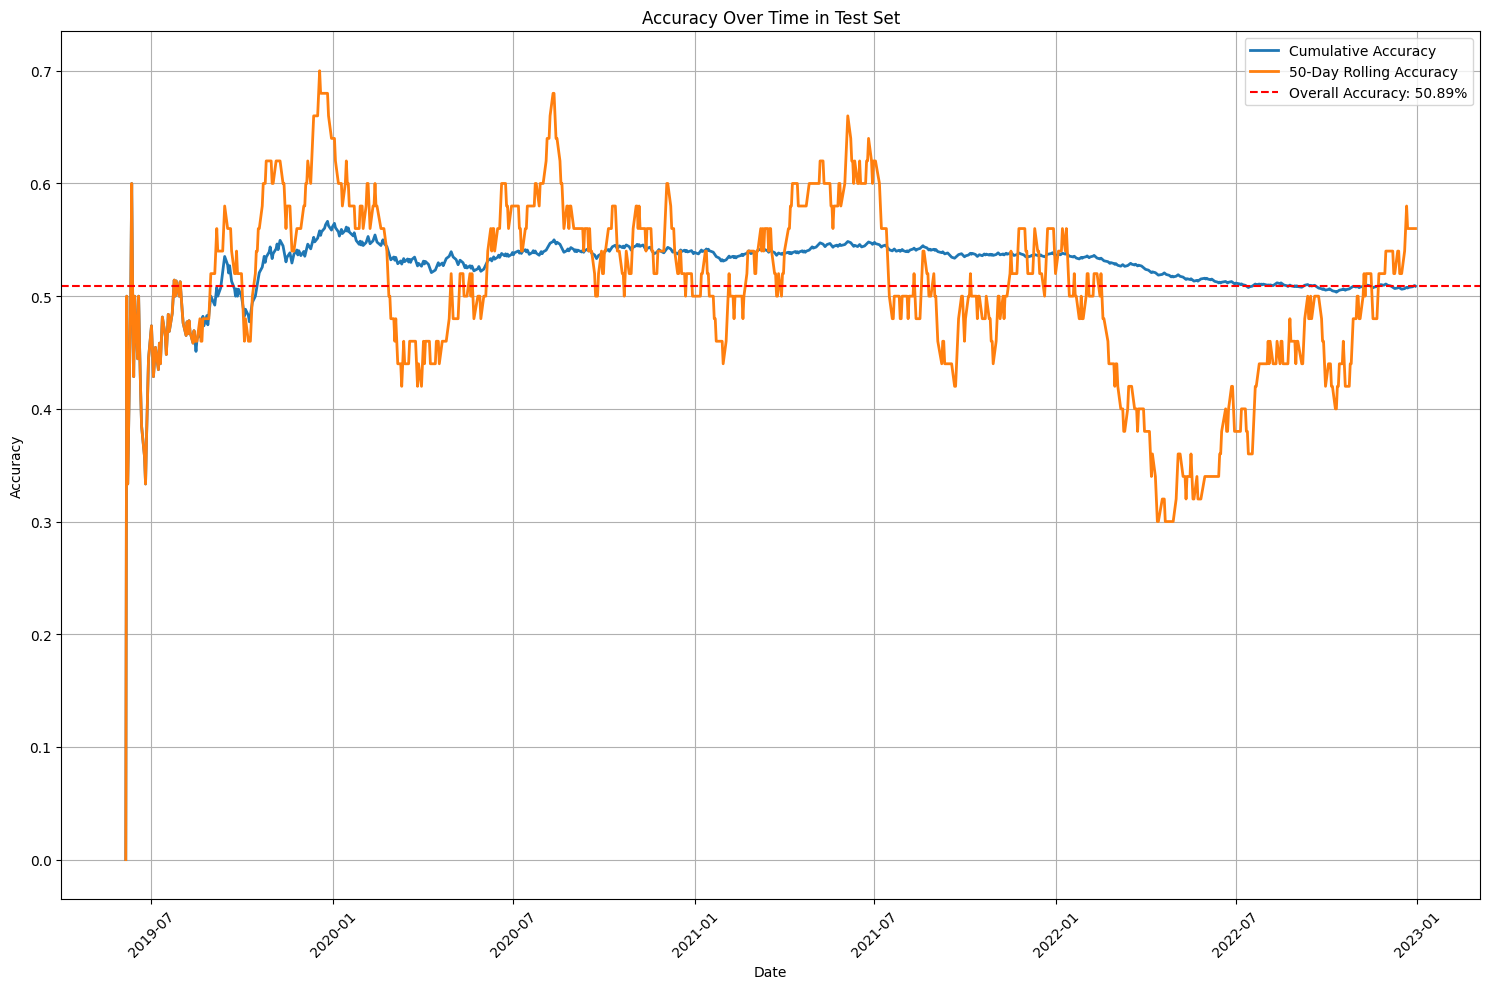

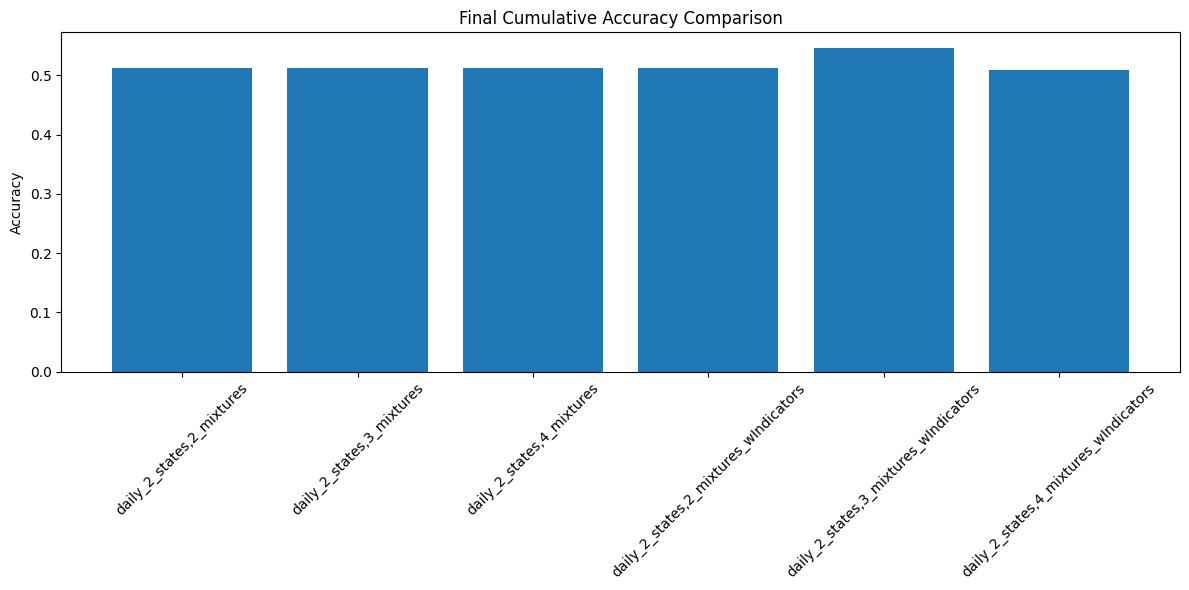

In [133]:
model_results = {}
n_states = 2
for n_mix in [2, 3 ,4]:
    print(f"\nEvaluating model with {n_states} states, {n_mix} states ...")
    model_results[f'daily_{2}_states,{n_mix}_mixtures'] = evaluate_predictions_with_cumulative(
        data, 
        "daily", 
        n_states,
        n_mix, 
        w_indicators=False, 
        window_size=50
    )

# Compare final accuracies
plt.figure(figsize=(12, 6))
final_accuracies = [results['cumulative_accuracy'][-1] for results in model_results.values()]
model_names = list(model_results.keys())
plt.bar(model_names, final_accuracies)
plt.title('Final Cumulative Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

for n_mix in [2, 3, 4]:
    print(f"\nEvaluating model with {n_mix} states...")
    model_results[f'daily_{2}_states,{n_mix}_mixtures_wIndicators'] = evaluate_predictions_with_cumulative(
        data, 
        "daily", 
        n_states,
        n_mix, 
        w_indicators=True, 
        window_size=50
    )
# Compare final accuracies
plt.figure(figsize=(12, 6))
final_accuracies = [results['cumulative_accuracy'][-1] for results in model_results.values()]
model_names = list(model_results.keys())
plt.bar(model_names, final_accuracies)
plt.title('Final Cumulative Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()